In [662]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import requests
import scipy.stats as sps
import arviz as az

az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

sns.set()

In [663]:
start_date = '2020-03-01'
end_date = '2020-08-20'

url = 'https://covidtrackerapi.bsg.ox.ac.uk/api/v2/stringency/date-range/{}/{}'.format(start_date,end_date)

r = requests.get(url,timeout=5.0)
r.status_code

200

In [664]:
keys = pd.date_range(start_date,end_date)
keys

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-08-11', '2020-08-12', '2020-08-13', '2020-08-14',
               '2020-08-15', '2020-08-16', '2020-08-17', '2020-08-18',
               '2020-08-19', '2020-08-20'],
              dtype='datetime64[ns]', length=173, freq='D')

In [665]:
json = r.json()
data = json['data']
countries = json['countries']

In [666]:
data_list = []

for k in keys:
    date = k.date().strftime('%Y-%m-%d')
    for c in countries:
        try:
            data_list.append((date,c,data[date][c]['confirmed'],data[date][c]['deaths'],data[date][c]['stringency']))
        except KeyError:
            pass

In [667]:
df = pd.DataFrame(data_list,columns=['date','country','confirmed','dead','oxford_stringency'])
df['date'] = pd.to_datetime(df['date'])
df.set_index(['country','date'],inplace=True)
df.loc['GBR']

confirmed     dead  oxford_stringency
date                                             
2020-03-01       42.0      0.0              11.11
2020-03-02       47.0      0.0              11.11
2020-03-03       69.0      0.0              11.11
2020-03-04      109.0      0.0              11.11
2020-03-05      164.0      0.0              11.11
...               ...      ...                ...
2020-08-13   313798.0  41329.0              65.28
2020-08-17   318484.0  41366.0              65.28
2020-08-18   319197.0  41369.0              65.28
2020-08-19   320286.0  41381.0              65.28
2020-08-20   321098.0  41397.0              65.28

[170 rows x 3 columns]

In [668]:
average_ox_idx = df['oxford_stringency'].groupby(level=0).mean()
average_ox_idx

country
ABW    47.908462
AFG    72.494624
AGO    69.715434
AIA    49.845984
ALB    69.945491
         ...    
VUT    60.459529
YEM    41.809653
ZAF    74.168862
ZMB    45.481503
ZWE    71.729017
Name: oxford_stringency, Length: 185, dtype: float64

In [669]:
population = pd.read_csv('world_pop.csv',sep=';',thousands=',',header=None,index_col=0)
population.columns=['pop']
population.index.name='country'
population

pop
country                  
Afghanistan      38928346
Albania           2877797
Algeria          43851044
American Samoa      55191
Andorra             77265
...                   ...
Wallis & Futuna     11239
Western Sahara     597339
Yemen            29825964
Zambia           18383955
Zimbabwe         14862924

[240 rows x 1 columns]

In [670]:
three_letter_abb = pd.read_csv('three_letter_country_abb.csv',sep=';',header=None,index_col=2)
three_letter_abb = three_letter_abb[0]
three_letter_abb.loc['GBR']

'UK'

In [671]:
df = df.reset_index(level=1)

In [672]:
df.loc['GBR']

date  confirmed     dead  oxford_stringency
country                                                  
GBR     2020-03-01       42.0      0.0              11.11
GBR     2020-03-02       47.0      0.0              11.11
GBR     2020-03-03       69.0      0.0              11.11
GBR     2020-03-04      109.0      0.0              11.11
GBR     2020-03-05      164.0      0.0              11.11
...            ...        ...      ...                ...
GBR     2020-08-13   313798.0  41329.0              65.28
GBR     2020-08-17   318484.0  41366.0              65.28
GBR     2020-08-18   319197.0  41369.0              65.28
GBR     2020-08-19   320286.0  41381.0              65.28
GBR     2020-08-20   321098.0  41397.0              65.28

[170 rows x 4 columns]

In [673]:
df = df.join(three_letter_abb)

In [674]:
df.rename(columns={0 : 'country'},inplace=True)

In [675]:
df = df.join(average_ox_idx,lsuffix='_current',rsuffix='_mean')

In [676]:
df

date  confirmed   dead  oxford_stringency_current   country  \
ABW 2020-03-01        NaN    NaN                       0.00     Aruba   
ABW 2020-03-02        NaN    NaN                       0.00     Aruba   
ABW 2020-03-03        NaN    NaN                       0.00     Aruba   
ABW 2020-03-04        NaN    NaN                       0.00     Aruba   
ABW 2020-03-05        NaN    NaN                       0.00     Aruba   
..         ...        ...    ...                        ...       ...   
ZWE 2020-08-16     5176.0  130.0                      80.56  Zimbabwe   
ZWE 2020-08-17     5261.0  132.0                      80.56  Zimbabwe   
ZWE 2020-08-18     5308.0  135.0                      80.56  Zimbabwe   
ZWE 2020-08-19     5378.0  141.0                      80.56  Zimbabwe   
ZWE 2020-08-20     5643.0  150.0                      80.56  Zimbabwe   

     oxford_stringency_mean  
ABW               47.908462  
ABW               47.908462  
ABW               47.908462  
ABW               47.908462  
ABW               47.908462  
..                      ...  
ZWE               71.729017  
ZWE               71.729017  
ZWE               71.729017  
ZWE               71.729017  
ZWE               71.729017  

[33139 rows x 6 columns]

In [677]:
foo = df.merge(population,left_on='country',right_on=population.index)
foo['dead_per_M'] = foo['dead'] / (foo['pop'] / 1e6)
foo

date  confirmed   dead  oxford_stringency_current   country  \
0     2020-03-01        NaN    NaN                       0.00     Aruba   
1     2020-03-02        NaN    NaN                       0.00     Aruba   
2     2020-03-03        NaN    NaN                       0.00     Aruba   
3     2020-03-04        NaN    NaN                       0.00     Aruba   
4     2020-03-05        NaN    NaN                       0.00     Aruba   
...          ...        ...    ...                        ...       ...   
28989 2020-08-16     5176.0  130.0                      80.56  Zimbabwe   
28990 2020-08-17     5261.0  132.0                      80.56  Zimbabwe   
28991 2020-08-18     5308.0  135.0                      80.56  Zimbabwe   
28992 2020-08-19     5378.0  141.0                      80.56  Zimbabwe   
28993 2020-08-20     5643.0  150.0                      80.56  Zimbabwe   

       oxford_stringency_mean       pop  dead_per_M  
0                   47.908462    106766         NaN  
1                   47.908462    106766         NaN  
2                   47.908462    106766         NaN  
3                   47.908462    106766         NaN  
4                   47.908462    106766         NaN  
...                       ...       ...         ...  
28989               71.729017  14862924    8.746597  
28990               71.729017  14862924    8.881160  
28991               71.729017  14862924    9.083004  
28992               71.729017  14862924    9.486693  
28993               71.729017  14862924   10.092227  

[28994 rows x 8 columns]

In [678]:
three_letter_abb.name='country'
three_letter_abb.index.name='abb'
three_letter_abb = pd.DataFrame(three_letter_abb)
three_letter_abb.columns=['country']
three_letter_abb.reset_index(inplace=True)


In [679]:
three_letter_abb

abb         country
0    AFG     Afghanistan
1    ALB         Albania
2    DZA         Algeria
3    ASM  American Samoa
4    AND         Andorra
..   ...             ...
256  ESH  Western Sahara
257  YEM           Yemen
258  ZMB          Zambia
259  ZWE        Zimbabwe
260  ALA   Åland Islands

[261 rows x 2 columns]

In [680]:
foo = foo.merge(three_letter_abb,left_on='country',right_on='country')
foo

date  confirmed   dead  oxford_stringency_current   country  \
0     2020-03-01        NaN    NaN                       0.00     Aruba   
1     2020-03-02        NaN    NaN                       0.00     Aruba   
2     2020-03-03        NaN    NaN                       0.00     Aruba   
3     2020-03-04        NaN    NaN                       0.00     Aruba   
4     2020-03-05        NaN    NaN                       0.00     Aruba   
...          ...        ...    ...                        ...       ...   
28989 2020-08-16     5176.0  130.0                      80.56  Zimbabwe   
28990 2020-08-17     5261.0  132.0                      80.56  Zimbabwe   
28991 2020-08-18     5308.0  135.0                      80.56  Zimbabwe   
28992 2020-08-19     5378.0  141.0                      80.56  Zimbabwe   
28993 2020-08-20     5643.0  150.0                      80.56  Zimbabwe   

       oxford_stringency_mean       pop  dead_per_M  abb  
0                   47.908462    106766         NaN  ABW  
1                   47.908462    106766         NaN  ABW  
2                   47.908462    106766         NaN  ABW  
3                   47.908462    106766         NaN  ABW  
4                   47.908462    106766         NaN  ABW  
...                       ...       ...         ...  ...  
28989               71.729017  14862924    8.746597  ZWE  
28990               71.729017  14862924    8.881160  ZWE  
28991               71.729017  14862924    9.083004  ZWE  
28992               71.729017  14862924    9.486693  ZWE  
28993               71.729017  14862924   10.092227  ZWE  

[28994 rows x 9 columns]

In [681]:
gbr = foo.loc[foo['abb'] == 'GBR']
gbr

date  confirmed     dead  oxford_stringency_current country  \
9758 2020-03-01       42.0      0.0                      11.11      UK   
9759 2020-03-02       47.0      0.0                      11.11      UK   
9760 2020-03-03       69.0      0.0                      11.11      UK   
9761 2020-03-04      109.0      0.0                      11.11      UK   
9762 2020-03-05      164.0      0.0                      11.11      UK   
...         ...        ...      ...                        ...     ...   
9923 2020-08-13   313798.0  41329.0                      65.28      UK   
9924 2020-08-17   318484.0  41366.0                      65.28      UK   
9925 2020-08-18   319197.0  41369.0                      65.28      UK   
9926 2020-08-19   320286.0  41381.0                      65.28      UK   
9927 2020-08-20   321098.0  41397.0                      65.28      UK   

      oxford_stringency_mean       pop  dead_per_M  abb  
9758               63.982412  67886011    0.000000  GBR  
9759               63.982412  67886011    0.000000  GBR  
9760               63.982412  67886011    0.000000  GBR  
9761               63.982412  67886011    0.000000  GBR  
9762               63.982412  67886011    0.000000  GBR  
...                      ...       ...         ...  ...  
9923               63.982412  67886011  608.799948  GBR  
9924               63.982412  67886011  609.344980  GBR  
9925               63.982412  67886011  609.389172  GBR  
9926               63.982412  67886011  609.565938  GBR  
9927               63.982412  67886011  609.801628  GBR  

[170 rows x 9 columns]

In [682]:
last_data_date = gbr['date'].iloc[-1]
last_data_date

Timestamp('2020-08-20 00:00:00')

In [683]:
def standardize(series):
    return (series - series.mean()) / series.std()

In [684]:
last_days = foo.loc[foo['date'] == last_data_date]
drop = ['San Marino','Andorra']

mask = last_days['country'].isin(drop)
last_days = last_days[~mask]

#last_days = last_days.merge(three_letter_abb,left_on='country',right_on='country')

last_days['conf_per_M'] = last_days['confirmed'] / (last_days['pop'] / 1e6)

### MASK ###
mask2 = last_days['dead_per_M'] > 10
############

last_days = last_days[mask2]
last_days['dead_per_M_log'] = np.log10(last_days['dead_per_M'])
last_days['ox_std'] = standardize(last_days['oxford_stringency_current'])
last_days['dead_per_M_inc'] = last_days['dead_per_M'] - last_days['dead_per_M'].shift()
last_days['dead_per_M_inc_std'] = standardize(last_days['dead_per_M_inc'])
last_days.dropna(inplace=True)

last_days

date  confirmed      dead  oxford_stringency_current  \
341   2020-08-20    37759.0    1383.0                      62.04   
814   2020-08-20     7812.0     234.0                      53.70   
1159  2020-08-20    65341.0     367.0                      29.63   
1332  2020-08-20   305953.0    6114.0                      87.96   
1501  2020-08-20    23993.0     450.0                      79.17   
...          ...        ...       ...                        ...   
27964 2020-08-20  5529842.0  173177.0                      68.98   
28480 2020-08-20     1893.0     539.0                      31.48   
28647 2020-08-20   596060.0   12423.0                      80.56   
28820 2020-08-20    10218.0     269.0                      50.93   
28993 2020-08-20     5643.0     150.0                      80.56   

                    country  oxford_stringency_mean        pop  dead_per_M  \
341             Afghanistan               72.494624   38928346   35.526811   
814                 Albania               69.945491    2877797   81.312198   
1159   United Arab Emirates               61.772674    9890402   37.106682   
1332              Argentina               84.590694   45195774  135.278135   
1501              Australia               61.724556   25499884   17.647139   
...                     ...                     ...        ...         ...   
27964                    US               66.430173  331002651  523.189163   
28480                 Yemen               41.809653   29825964   18.071503   
28647          South Africa               74.168862   59308690  209.463402   
28820                Zambia               45.481503   18383955   14.632325   
28993              Zimbabwe               71.729017   14862924   10.092227   

       abb    conf_per_M  dead_per_M_log    ox_std  dead_per_M_inc  \
341    AFG    969.961580        1.550556  0.161328      -11.304577   
814    ALB   2714.576462        1.910156 -0.246970       45.785387   
1159   ARE   6606.505984        1.569452 -1.425356      -44.205516   
1332   ARG   6769.504600        2.131228  1.430283       98.171453   
1501   AUS    940.906241        1.246674  0.999955     -117.630996   
...    ...           ...             ...       ...             ...   
27964  USA  16706.337497        2.718659  0.501087      511.674163   
28480  YEM     63.468192        1.256994 -1.334786     -505.117660   
28647  ZAF  10050.129248        2.321108  1.068004      191.391899   
28820  ZMB    555.810760        1.165313 -0.382580     -194.831078   
28993  ZWE    379.669572        1.003987  1.068004       -4.540098   

       dead_per_M_inc_std  
341             -0.040528  
814              0.170617  
1159            -0.162211  
1332             0.364365  
1501            -0.433772  
...                   ...  
27964            1.893689  
28480           -1.866877  
28647            0.709138  
28820           -0.719294  
28993           -0.015510  

[106 rows x 14 columns]

In [685]:
last_days.sort_values('oxford_stringency_mean',ascending=True).head(50)



date  confirmed     dead  oxford_stringency_current  \
3399  2020-08-20    69801.0    622.0                      11.11   
19579 2020-08-20     4311.0    133.0                      16.67   
25214 2020-08-20    85411.0   5802.0                      37.04   
13457 2020-08-20     2035.0     10.0                      39.81   
28480 2020-08-20     1893.0    539.0                      31.48   
8897  2020-08-20     2207.0     63.0                      19.44   
9242  2020-08-20     7776.0    334.0                      37.96   
28820 2020-08-20    10218.0    269.0                      50.93   
27791 2020-08-20     1493.0     40.0                      22.22   
16374 2020-08-20     7566.0    124.0                      22.22   
2883  2020-08-20    14669.0    519.0                      30.56   
19919 2020-08-20    10111.0    262.0                      34.26   
6994  2020-08-20    20798.0    404.0                      36.11   
16547 2020-08-20     1326.0     33.0                      43.52   
25041 2020-08-20     2493.0    125.0                      43.52   
16211 2020-08-20     2496.0     81.0                      19.44   
1674  2020-08-20    24300.0    729.0                      31.48   
13114 2020-08-20   347835.0  19972.0                      62.96   
12092 2020-08-20     7074.0    168.0                      31.48   
5277  2020-08-20    38662.0   1718.0                      44.91   
23161 2020-08-20    12446.0    258.0                      32.41   
19066 2020-08-20     4665.0     39.0                      60.19   
5962  2020-08-20    18624.0    406.0                      60.19   
24356 2020-08-20    30048.0    684.0                      45.37   
11749 2020-08-20     4604.0     75.0                      66.67   
19752 2020-08-20    64463.0   6172.0                      45.37   
4936  2020-08-20     4679.0     61.0                      54.63   
18257 2020-08-20     6829.0    158.0                      29.63   
21454 2020-08-20    58611.0   1913.0                      39.81   
7340  2020-08-20     5374.0     59.0                      45.37   
12438 2020-08-20     5002.0    609.0                      49.07   
3742  2020-08-20      166.0      9.0                      48.15   
11414 2020-08-20      599.0      5.0                      79.63   
12265 2020-08-20     7949.0    196.0                      17.59   
10902 2020-08-20     7684.0    235.0                      56.02   
7167  2020-08-20   228621.0   9253.0                      56.94   
22297 2020-08-20    73617.0   3106.0                      45.37   
27101 2020-08-20   253108.0   6039.0                      48.15   
12942 2020-08-20    27547.0   1775.0                      38.89   
1501  2020-08-20    23993.0    450.0                      79.17   
7686  2020-08-20    15940.0    621.0                      56.48   
1159  2020-08-20    65341.0    367.0                      29.63   
12605 2020-08-20   144945.0   6346.0                      62.50   
2193  2020-08-20    80814.0   9982.0                      56.48   
9927  2020-08-20   321098.0  41397.0                      65.28   
10729 2020-08-20     2288.0     77.0                      77.78   
4251  2020-08-20      155.0      7.0                      50.93   
27618 2020-08-20    96403.0   2144.0                      54.17   
3569  2020-08-20      553.0      5.0                      70.83   
5104  2020-08-20   123490.0   9049.0                      67.13   

                        country  oxford_stringency_mean        pop  \
3399                    Belarus               11.911118    9449323   
19579                 Nicaragua               12.158743    6624554   
25214                    Sweden               37.991965   10099265   
13457                   Iceland               40.346882     341243   
28480                     Yemen               41.809653   29825964   
8897                    Estonia               42.661098    1326535   
9242                    Finland               44.278547    5540720   
28820                    Zambia   

In [686]:
last_days.shape

(106, 14)

In [687]:
foo.dropna(inplace=True)
foo

date  confirmed   dead  oxford_stringency_current   country  \
12    2020-03-13        2.0    0.0                       0.00     Aruba   
19    2020-03-20        4.0    0.0                      33.33     Aruba   
23    2020-03-24       12.0    0.0                      44.44     Aruba   
24    2020-03-25       17.0    0.0                      44.44     Aruba   
25    2020-03-26       19.0    0.0                      44.44     Aruba   
...          ...        ...    ...                        ...       ...   
28989 2020-08-16     5176.0  130.0                      80.56  Zimbabwe   
28990 2020-08-17     5261.0  132.0                      80.56  Zimbabwe   
28991 2020-08-18     5308.0  135.0                      80.56  Zimbabwe   
28992 2020-08-19     5378.0  141.0                      80.56  Zimbabwe   
28993 2020-08-20     5643.0  150.0                      80.56  Zimbabwe   

       oxford_stringency_mean       pop  dead_per_M  abb  
12                  47.908462    106766    0.000000  ABW  
19                  47.908462    106766    0.000000  ABW  
23                  47.908462    106766    0.000000  ABW  
24                  47.908462    106766    0.000000  ABW  
25                  47.908462    106766    0.000000  ABW  
...                       ...       ...         ...  ...  
28989               71.729017  14862924    8.746597  ZWE  
28990               71.729017  14862924    8.881160  ZWE  
28991               71.729017  14862924    9.083004  ZWE  
28992               71.729017  14862924    9.486693  ZWE  
28993               71.729017  14862924   10.092227  ZWE  

[26442 rows x 9 columns]

In [688]:
selected_countries = ['USA','Peru','Argentina','Sweden','United Kingdom','Australia','New Zealand']

#foo = foo.loc[foo['country'].isin(selected_countries)].copy()

abb_to_idx = dict(zip(foo['country'].unique(),range(len(foo['country'].unique()))))
abb_to_idx

{'Aruba': 0,
 'Afghanistan': 1,
 'Angola': 2,
 'Anguilla': 3,
 'Albania': 4,
 'Andorra': 5,
 'United Arab Emirates': 6,
 'Argentina': 7,
 'Australia': 8,
 'Austria': 9,
 'Azerbaijan': 10,
 'Burundi': 11,
 'Belgium': 12,
 'Benin': 13,
 'Burkina Faso': 14,
 'Bangladesh': 15,
 'Bulgaria': 16,
 'Bahrain': 17,
 'Bosnia and Herzegovina': 18,
 'Belarus': 19,
 'Belize': 20,
 'Bermuda': 21,
 'Bolivia': 22,
 'Brazil': 23,
 'Barbados': 24,
 'Brunei': 25,
 'Bhutan': 26,
 'Botswana': 27,
 'Central African Republic': 28,
 'Canada': 29,
 'Switzerland': 30,
 'Chile': 31,
 'China': 32,
 "Côte d'Ivoire": 33,
 'Cameroon': 34,
 'Colombia': 35,
 'Cabo Verde': 36,
 'Costa Rica': 37,
 'Cuba': 38,
 'Cyprus': 39,
 'Czechia': 40,
 'Germany': 41,
 'Djibouti': 42,
 'Dominica': 43,
 'Denmark': 44,
 'Dominican Republic': 45,
 'Algeria': 46,
 'Ecuador': 47,
 'Egypt': 48,
 'Eritrea': 49,
 'Spain': 50,
 'Estonia': 51,
 'Ethiopia': 52,
 'Finland': 53,
 'Fiji': 54,
 'France': 55,
 'Gabon': 56,
 'UK': 57,
 'Georgia': 58,

In [689]:
foo['country_idx'] = foo['country'].apply(lambda x :abb_to_idx[x])
foo['dead_per_M_std'] = standardize(foo['dead_per_M'])
foo['oxford_curr_std'] = standardize(foo['oxford_stringency_current'])
foo['dead_per_M_std_inc'] = foo['dead_per_M_std'] - foo['dead_per_M_std'].shift()
foo.dropna(inplace=True)

mask = (foo['dead'] > 10) | (foo['confirmed'] > 100)
foo = foo[mask]
foo

date  confirmed   dead  oxford_stringency_current   country  \
67    2020-05-07      101.0    2.0                      81.48     Aruba   
68    2020-05-08      101.0    3.0                      81.48     Aruba   
69    2020-05-09      101.0    3.0                      81.48     Aruba   
70    2020-05-10      101.0    3.0                      81.48     Aruba   
71    2020-05-11      101.0    3.0                      81.48     Aruba   
...          ...        ...    ...                        ...       ...   
28989 2020-08-16     5176.0  130.0                      80.56  Zimbabwe   
28990 2020-08-17     5261.0  132.0                      80.56  Zimbabwe   
28991 2020-08-18     5308.0  135.0                      80.56  Zimbabwe   
28992 2020-08-19     5378.0  141.0                      80.56  Zimbabwe   
28993 2020-08-20     5643.0  150.0                      80.56  Zimbabwe   

       oxford_stringency_mean       pop  dead_per_M  abb  country_idx  \
67                  47.908462    106766   18.732555  ABW            0   
68                  47.908462    106766   28.098833  ABW            0   
69                  47.908462    106766   28.098833  ABW            0   
70                  47.908462    106766   28.098833  ABW            0   
71                  47.908462    106766   28.098833  ABW            0   
...                       ...       ...         ...  ...          ...   
28989               71.729017  14862924    8.746597  ZWE          165   
28990               71.729017  14862924    8.881160  ZWE          165   
28991               71.729017  14862924    9.083004  ZWE          165   
28992               71.729017  14862924    9.486693  ZWE          165   
28993               71.729017  14862924   10.092227  ZWE          165   

       dead_per_M_std  oxford_curr_std  dead_per_M_std_inc  
67          -0.245292         0.742039            0.000000  
68          -0.181460         0.742039            0.063832  
69          -0.181460         0.742039            0.000000  
70          -0.181460         0.742039            0.000000  
71          -0.181460         0.742039            0.000000  
...               ...              ...                 ...  
28989       -0.313347         0.699663            0.000917  
28990       -0.312430         0.699663            0.000917  
28991       -0.311054         0.699663            0.001376  
28992       -0.308303         0.699663            0.002751  
28993       -0.304176         0.699663            0.004127  

[21432 rows x 13 columns]

In [690]:
x = foo['oxford_curr_std']
country_idx = foo['country_idx'].values

y_param = 'dead_per_M_std_inc'

model = pm.Model()


with model:


    if y_param == 'dead_per_M_std_inc':
        beta_mean = pm.Normal('beta_mean',0,1)
        beta_std = pm.Exponential('beta_mean_std',1)
        alpha_mean = pm.Normal('alpha_mean',0,1)
        alpha_mean_std = pm.Exponential('alpha_mean_std',1)
        alpha_high = 1
        obs_sigma_high = 1

    else:
        beta_mean = 0
        beta_std = 1000
        alpha_low = -4000
        alpha_high = 4000
        obs_sigma_high = 10000


    alpha = pm.Normal('alpha',alpha_mean,alpha_mean_std,shape=len(abb_to_idx))
    #beta = pm.Uniform('beta',beta_low,beta_high)
    beta = pm.Normal('beta',mu=beta_mean, sd=beta_std,shape=len(abb_to_idx) )
    obs_sigma = pm.Uniform('obs_sigma',0,obs_sigma_high)

    
    linreq = alpha[country_idx] + x.values * beta[country_idx]

    #linreq = alpha + x.values * beta

    obs = pm.Normal('obs',mu = linreq,sd=obs_sigma,observed = foo[y_param])

    
    trace = pm.sample(500,tune=500,target_accept=0.80)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha, alpha_mean_std, alpha_mean, beta_mean_std, beta_mean]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 64 seconds.


In [691]:
result = pd.DataFrame()

with model:
    result = pm.trace_to_dataframe(trace)
    
result.describe()

beta_mean   alpha_mean     alpha__0     alpha__1     alpha__2  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.003156     0.006283     0.005624     0.001972     0.000748   
std       0.001202     0.001103     0.005459     0.005712     0.007131   
min      -0.000179     0.003080    -0.015501    -0.015165    -0.018183   
25%       0.002321     0.005529     0.002042    -0.001699    -0.004183   
50%       0.003187     0.006287     0.005644     0.001865     0.000610   
75%       0.004026     0.007023     0.009174     0.006066     0.005616   
max       0.007165     0.009596     0.022551     0.019724     0.023883   

          alpha__3     alpha__4     alpha__5     alpha__6     alpha__7  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.006164     0.005088     0.061848     0.001833     0.009245  ...   
std       0.011587     0.003146     0.007029     0.002903     0.008779  ...   
min      -0.041199    -0.005265     0.042626    -0.007071    -0.017064  ...   
25%      -0.001294     0.002875     0.056956    -0.000110     0.003297  ...   
50%       0.005993     0.005202     0.061606     0.001799     0.008969  ...   
75%       0.013903     0.007276     0.066716     0.003770     0.015272  ...   
max       0.058136     0.014896     0.089096     0.011376     0.036861  ...   

         beta__159    beta__160    beta__161    beta__162    beta__163  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.000774     0.010483    -0.000347     0.001404    -0.001016   
std       0.003342     0.004326     0.005254     0.005196     0.006657   
min      -0.008974    -0.004935    -0.017732    -0.015729    -0.028321   
25%      -0.001483     0.007212    -0.003911    -0.002155    -0.005707   
50%       0.000748     0.010580    -0.000362     0.001541    -0.001059   
75%       0.003091     0.013594     0.003079     0.004823     0.003528   
max       0.012272     0.023172     0.016573     0.015653     0.019549   

         beta__164    beta__165  beta_mean_std  alpha_mean_std    obs_sigma  
count  1000.000000  1000.000000    1000.000000     1000.000000  1000.000000  
mean      0.002853     0.000553       0.013396        0.011924     0.036276  
std       0.007017     0.009087       0.001028        0.000901     0.000174  
min      -0.024398    -0.027913       0.010497        0.009325     0.035689  
25%      -0.001608    -0.005790       0.012660        0.011280     0.036162  
50%       0.002890     0.000487       0.013312        0.011891     0.036275  
75%       0.007500     0.006961       0.014028        0.012526     0.036384  
max       0.026861     0.033240       0.017156        0.015359     0.036869  

[8 rows x 337 columns]

In [692]:
def param_type(colName):
    if 'mean' in colName :
        return colName
    
    elif 'beta' in colName :
        return 'beta'
    elif 'alpha' in colName:
        return 'alpha'
    else:
        return colName
    
grp = result.groupby(param_type,axis=1)

alphas = grp.get_group('alpha')
betas = grp.get_group('beta')
sigmas = grp.get_group('obs_sigma')

alphas_means = alphas.mean()
betas_means = betas.mean()
obs_sigma_mean = sigmas.mean()

betas_means

beta__0      0.003301
beta__1      0.000054
beta__2      0.000297
beta__3      0.002809
beta__4     -0.003960
               ...   
beta__161   -0.000347
beta__162    0.001404
beta__163   -0.001016
beta__164    0.002853
beta__165    0.000553
Length: 166, dtype: float64

In [693]:
inv_map = {v: k for k, v in abb_to_idx.items()}
alphas_means.index = inv_map.values()
betas_means.index = inv_map.values()
betas_means.max()
inv_map[betas_means.argmin()]
inv_map


{0: 'Aruba',
 1: 'Afghanistan',
 2: 'Angola',
 3: 'Anguilla',
 4: 'Albania',
 5: 'Andorra',
 6: 'United Arab Emirates',
 7: 'Argentina',
 8: 'Australia',
 9: 'Austria',
 10: 'Azerbaijan',
 11: 'Burundi',
 12: 'Belgium',
 13: 'Benin',
 14: 'Burkina Faso',
 15: 'Bangladesh',
 16: 'Bulgaria',
 17: 'Bahrain',
 18: 'Bosnia and Herzegovina',
 19: 'Belarus',
 20: 'Belize',
 21: 'Bermuda',
 22: 'Bolivia',
 23: 'Brazil',
 24: 'Barbados',
 25: 'Brunei',
 26: 'Bhutan',
 27: 'Botswana',
 28: 'Central African Republic',
 29: 'Canada',
 30: 'Switzerland',
 31: 'Chile',
 32: 'China',
 33: "Côte d'Ivoire",
 34: 'Cameroon',
 35: 'Colombia',
 36: 'Cabo Verde',
 37: 'Costa Rica',
 38: 'Cuba',
 39: 'Cyprus',
 40: 'Czechia',
 41: 'Germany',
 42: 'Djibouti',
 43: 'Dominica',
 44: 'Denmark',
 45: 'Dominican Republic',
 46: 'Algeria',
 47: 'Ecuador',
 48: 'Egypt',
 49: 'Eritrea',
 50: 'Spain',
 51: 'Estonia',
 52: 'Ethiopia',
 53: 'Finland',
 54: 'Fiji',
 55: 'France',
 56: 'Gabon',
 57: 'UK',
 58: 'Georgia',

In [694]:
X = np.linspace(-3,3,100)

lines = np.array([alphas_means[i] + betas_means[i] * X for i in range(len(alphas_means))])


In [695]:
functions = np.array([betas_means[i] for i in range(len(betas_means))])
functions = pd.DataFrame(functions,index=inv_map.values())
functions

0
Aruba         0.003301
Afghanistan   0.000054
Angola        0.000297
Anguilla      0.002809
Albania      -0.003960
...                ...
Uzbekistan   -0.000347
Yemen         0.001404
South Africa -0.001016
Zambia        0.002853
Zimbabwe      0.000553

[166 rows x 1 columns]

<AxesSubplot:>

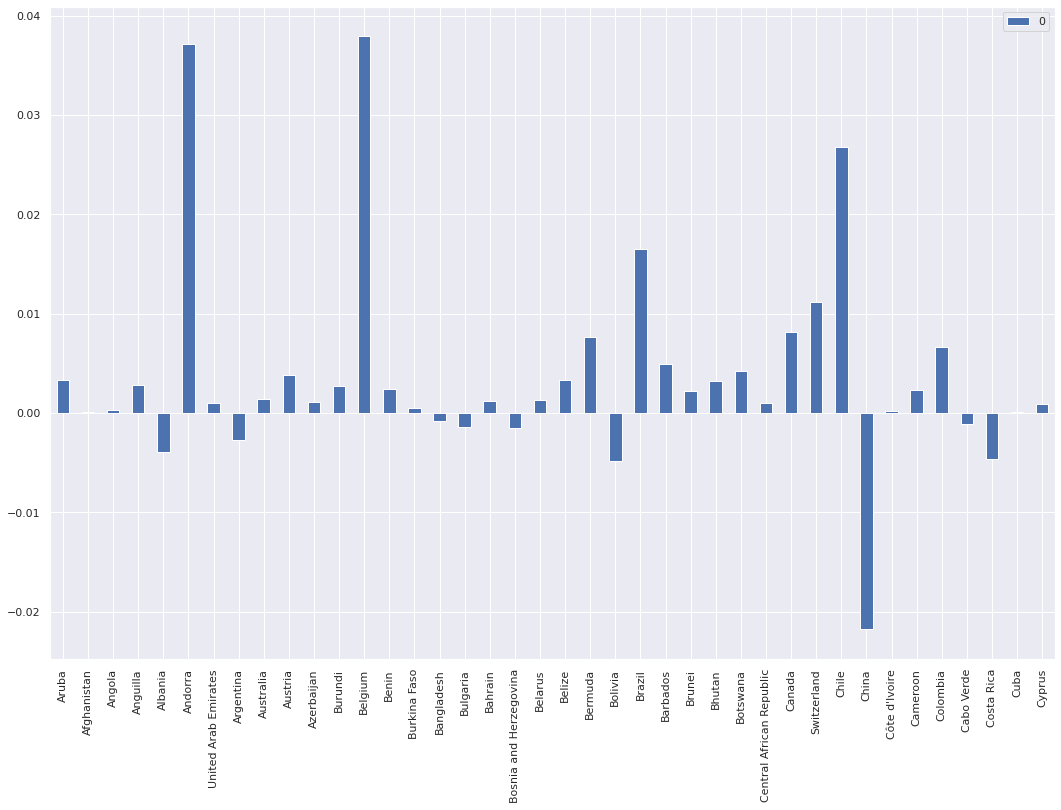

In [696]:
functions.iloc[:40].plot(figsize=(18,12),kind='bar')

<AxesSubplot:>

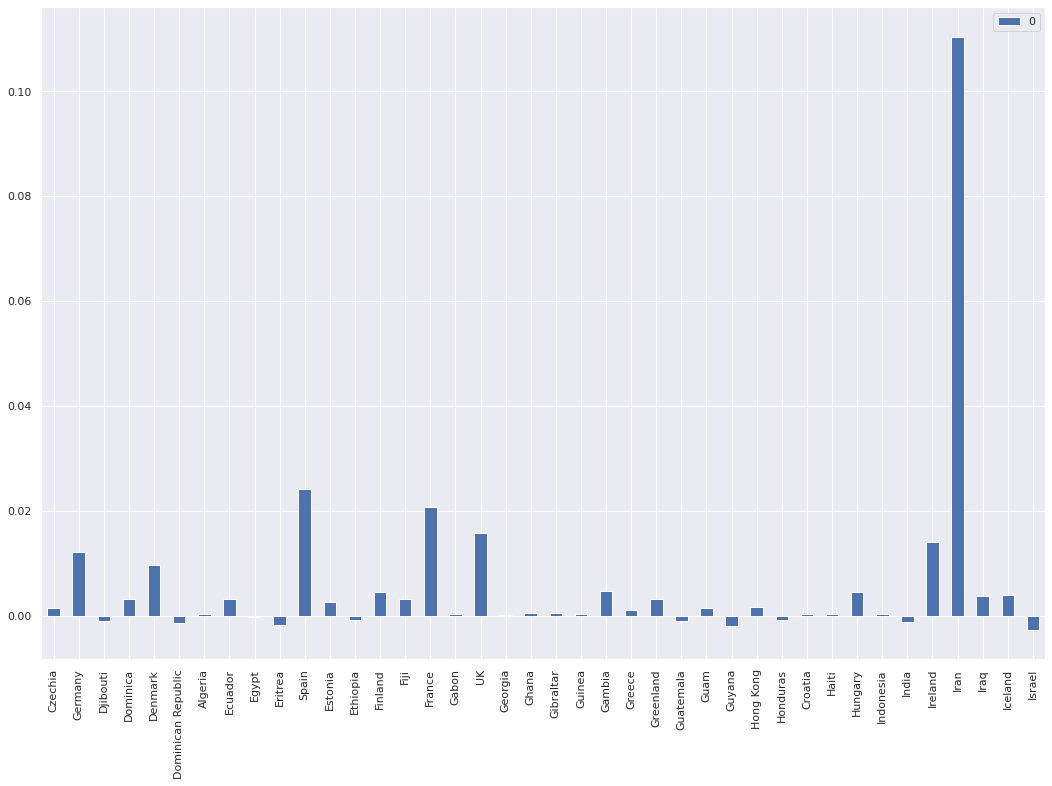

In [697]:
functions.iloc[40:80].plot(figsize=(18,12),kind='bar')

           date  confirmed  dead  oxford_stringency_current country  \
9637 2020-04-18      108.0   1.0                      81.48   Gabon   
9638 2020-04-19      109.0   1.0                      81.48   Gabon   
9639 2020-04-20      109.0   1.0                      81.48   Gabon   
9640 2020-04-21      120.0   1.0                      81.48   Gabon   
9641 2020-04-22      156.0   1.0                      81.48   Gabon   

      oxford_stringency_mean      pop  dead_per_M  abb  country_idx  \
9637               67.298225  2225734     0.44929  GAB           56   
9638               67.298225  2225734     0.44929  GAB           56   
9639               67.298225  2225734     0.44929  GAB           56   
9640               67.298225  2225734     0.44929  GAB           56   
9641               67.298225  2225734     0.44929  GAB           56   

      dead_per_M_std  oxford_curr_std  dead_per_M_std_inc  
9637       -0.369894         0.742039                 0.0  
9638       -0.369894      

confirmed          dead  \
confirmed                  1.000000e+00  9.884847e-01   
dead                       9.884847e-01  1.000000e+00   
oxford_stringency_current -9.008916e-01 -9.362936e-01   
oxford_stringency_mean     1.765784e-15  9.986864e-17   
pop                                 NaN           NaN   
dead_per_M                 9.884847e-01  1.000000e+00   
country_idx                         NaN           NaN   
dead_per_M_std             9.884847e-01  1.000000e+00   
oxford_curr_std           -9.008916e-01 -9.362936e-01   
dead_per_M_std_inc        -2.675107e-02 -8.984876e-03   

                           oxford_stringency_current  oxford_stringency_mean  \
confirmed                              -9.008916e-01            1.765784e-15   
dead                                   -9.362936e-01            9.986864e-17   
oxford_stringency_current               1.000000e+00           -3.040252e-15   
oxford_stringency_mean                 -3.040252e-15            1.000000e+00   
pop                                              NaN                     NaN   
dead_per_M                             -9.362936e-01            4.839990e-16   
country_idx                                      NaN                     NaN   
dead_per_M_std                         -9.362936e-01           -3.587929e-15   
oxford_curr_std                         1.000000e+00           -1.806348e-15   
dead_per_M_std_inc                     -9.144850e-03           -5.847444e-17   

                           pop    dead_per_M  country_idx  dead_per_M_std  \
confirmed                  NaN  9.884847e-01          NaN    9.884847e-01   
dead                       NaN  1.000000e+00          NaN    1.000000e+00   
oxford_stringency_current  NaN -9.362936e-01          NaN   -9.362936e-01   
oxford_stringency_mean     NaN  4.839990e-16          NaN   -3.587929e-15   
pop                        NaN           NaN          NaN             NaN   
dead_per_M                 NaN  1.000000e+00          NaN    1.000000e+00   
country_idx                NaN           NaN          NaN             NaN   
dead_per_M_std             NaN  1.000000e+00          NaN    1.000000e+00   
oxford_curr_std            NaN -9.362936e-01          NaN   -9.362936e-01   
dead_per_M_std_inc         NaN -8.984876e-03          NaN   -8.984876e-03   

                           oxford_curr_std  dead_per_M_std_inc  
confirmed                    -9.008916e-01       -2.675107e-02  
dead                         -9.362936e-01       -8.984876e-03  
oxford_stringency_current     1.000000e+00       -9.144850e-03  
oxford_stringency_mean       -1.806348e-15       -5.847444e-17  
pop                                    NaN                 NaN  
dead_per_M                   -9.362936e-01       -8.984876e-03  
country_idx                            NaN                 NaN  
dead_per_M_std               -9.362936e-01       -8.984876e-03  
oxford_curr_std               1.000000e+00       -9.144850e-03  
dead_per_M_std_inc           -9.144850e-03        1.000000e+00

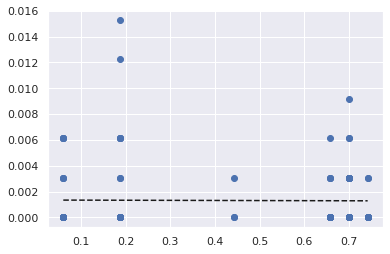

In [698]:
import scipy.stats as sps


gabon = foo.loc[foo['country'] == 'Gabon']
print (gabon.head())

slope,intercept,_,_,_ = sps.linregress(gabon['oxford_curr_std'],gabon['dead_per_M_std_inc'])

print (slope,intercept)

#gabon.plot(x='date',y=['dead_per_M_std_inc','oxford_curr_std'],color=['r','b'])
plt.scatter(gabon['oxford_curr_std'],gabon['dead_per_M_std_inc'])
X = np.linspace(gabon['oxford_curr_std'].min(),gabon['oxford_curr_std'].max(),100)
plt.plot(X,intercept + slope * X,color='k',ls='dashed')
gabon.corr()

<AxesSubplot:>

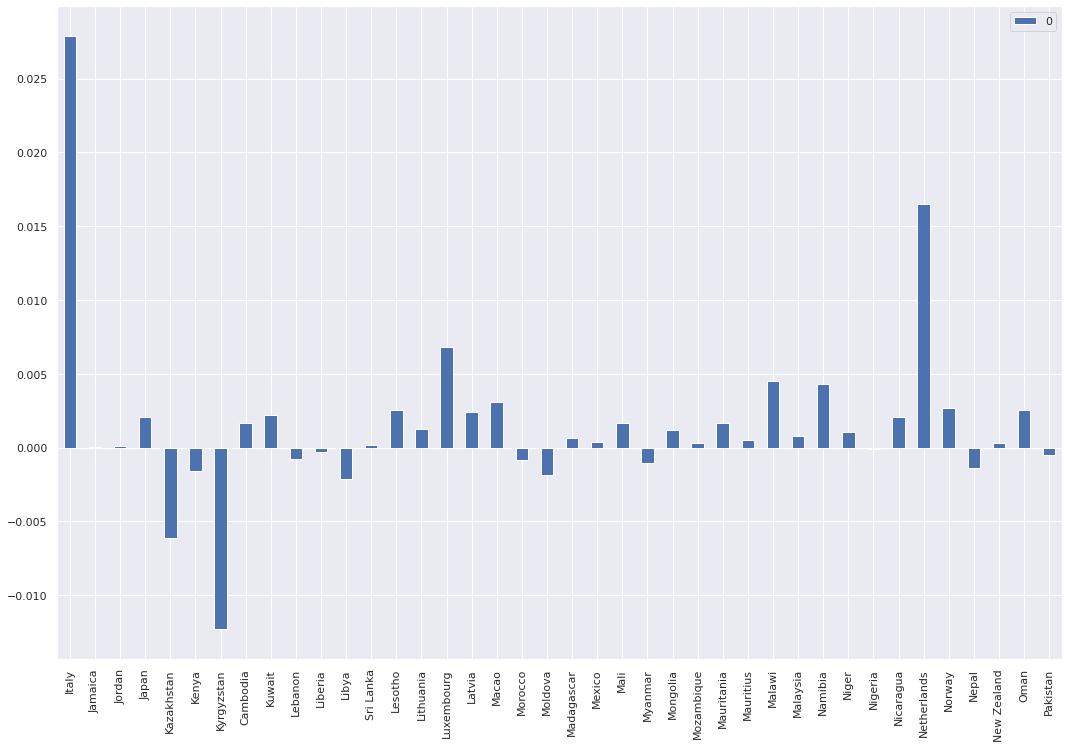

In [699]:
functions.iloc[80:120].plot(figsize=(18,12),kind='bar')

<AxesSubplot:>

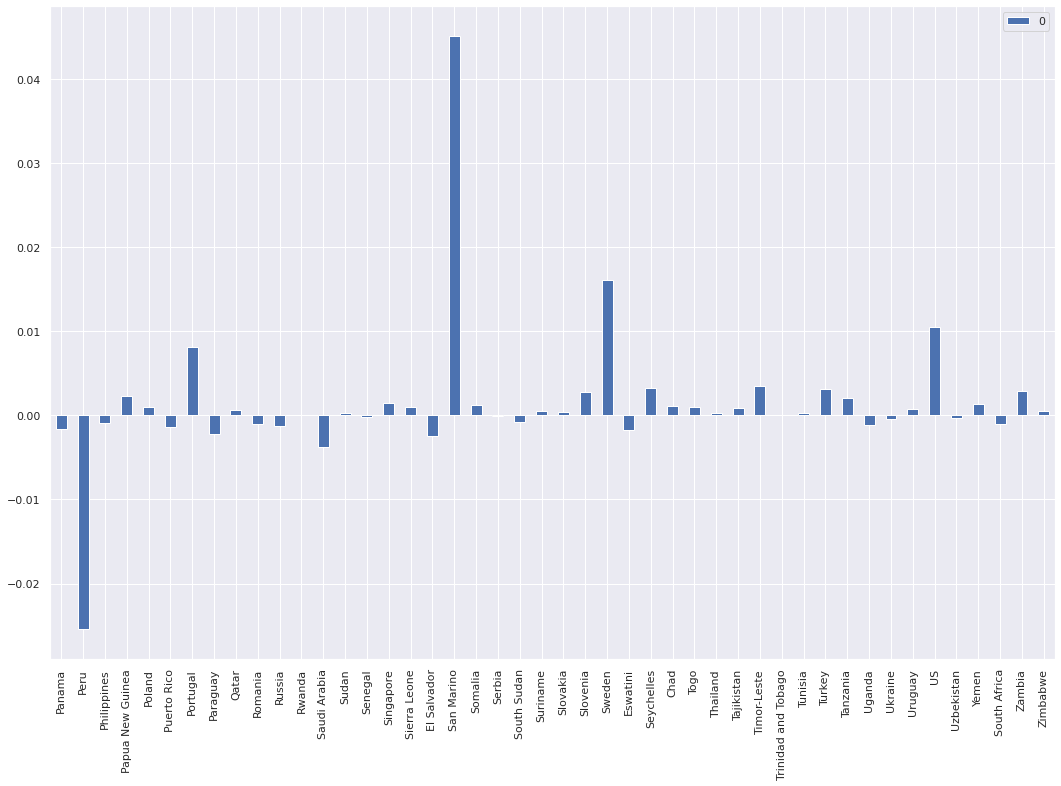

In [700]:
functions.iloc[120:].plot(figsize=(18,12),kind='bar')

-0.07914096589706024 0.12125914492552234


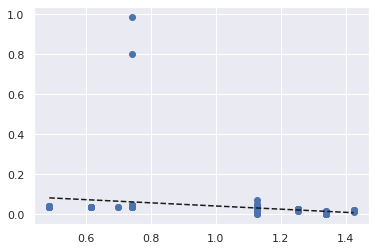

In [701]:
peru = foo.loc[foo['country'] == 'Peru']
plt.scatter(peru['oxford_curr_std'],peru['dead_per_M_std_inc'])
slope,intercept,_,_,_ = sps.linregress(peru['oxford_curr_std'],peru['dead_per_M_std_inc'])
print (slope,intercept)
X = np.linspace(peru['oxford_curr_std'].min(),peru['oxford_curr_std'].max(),100)
plt.plot(X,intercept + slope * X,color='k',ls='dashed')

In [702]:
foo.loc[foo['abb']=='SOM']

date  confirmed  dead  oxford_stringency_current  country  \
24059 2020-04-18      116.0   5.0                      60.19  Somalia   
24060 2020-04-19      135.0   7.0                      60.19  Somalia   
24061 2020-04-20      164.0   7.0                      60.19  Somalia   
24062 2020-04-21      237.0   8.0                      60.19  Somalia   
24063 2020-04-22      286.0   8.0                      60.19  Somalia   
...          ...        ...   ...                        ...      ...   
24179 2020-08-16     3256.0  93.0                      13.89  Somalia   
24180 2020-08-17     3256.0  93.0                      13.89  Somalia   
24181 2020-08-18     3257.0  93.0                      13.89  Somalia   
24182 2020-08-19     3257.0  93.0                      13.89  Somalia   
24183 2020-08-20     3265.0  93.0                      13.89  Somalia   

       oxford_stringency_mean       pop  dead_per_M  abb  country_idx  \
24059                41.01526  15893222    0.314600  SOM          139   
24060                41.01526  15893222    0.440439  SOM          139   
24061                41.01526  15893222    0.440439  SOM          139   
24062                41.01526  15893222    0.503359  SOM          139   
24063                41.01526  15893222    0.503359  SOM          139   
...                       ...       ...         ...  ...          ...   
24179                41.01526  15893222    5.851551  SOM          139   
24180                41.01526  15893222    5.851551  SOM          139   
24181                41.01526  15893222    5.851551  SOM          139   
24182                41.01526  15893222    5.851551  SOM          139   
24183                41.01526  15893222    5.851551  SOM          139   

       dead_per_M_std  oxford_curr_std  dead_per_M_std_inc  
24059       -0.370812        -0.238599            0.000000  
24060       -0.369954        -0.238599            0.000858  
24061       -0.369954        -0.238599            0.000000  
24062       -0.369525        -0.238599            0.000429  
24063       -0.369525        -0.238599            0.000000  
...               ...              ...                 ...  
24179       -0.333077        -2.371222            0.000000  
24180       -0.333077        -2.371222            0.000000  
24181       -0.333077        -2.371222            0.000000  
24182       -0.333077        -2.371222            0.000000  
24183       -0.333077        -2.371222            0.000000  

[125 rows x 13 columns]

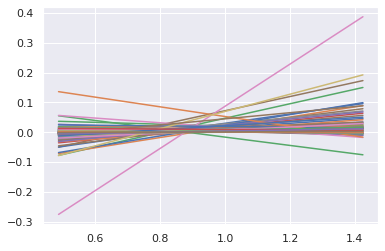

In [703]:
_= [ plt.plot(X,lines[i]) for i in range(len(lines))]

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/plots/traceplot.py:250: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (337), generating only 20 plots
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


                mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta_mean       0.00  0.00      0.00       0.01        0.0      0.0   1534.11   
alpha_mean      0.01  0.00      0.00       0.01        0.0      0.0   1468.38   
alpha[0]        0.01  0.01     -0.00       0.01        0.0      0.0   2099.78   
alpha[1]        0.00  0.01     -0.01       0.01        0.0      0.0   2412.89   
alpha[2]        0.00  0.01     -0.01       0.01        0.0      0.0   2763.73   
...              ...   ...       ...        ...        ...      ...       ...   
beta[164]       0.00  0.01     -0.01       0.01        0.0      0.0   2027.71   
beta[165]       0.00  0.01     -0.01       0.01        0.0      0.0   1964.40   
beta_mean_std   0.01  0.00      0.01       0.01        0.0      0.0    869.10   
alpha_mean_std  0.01  0.00      0.01       0.01        0.0      0.0    917.79   
obs_sigma       0.04  0.00      0.04       0.04        0.0      0.0   2858.91   

                 ess_sd  es

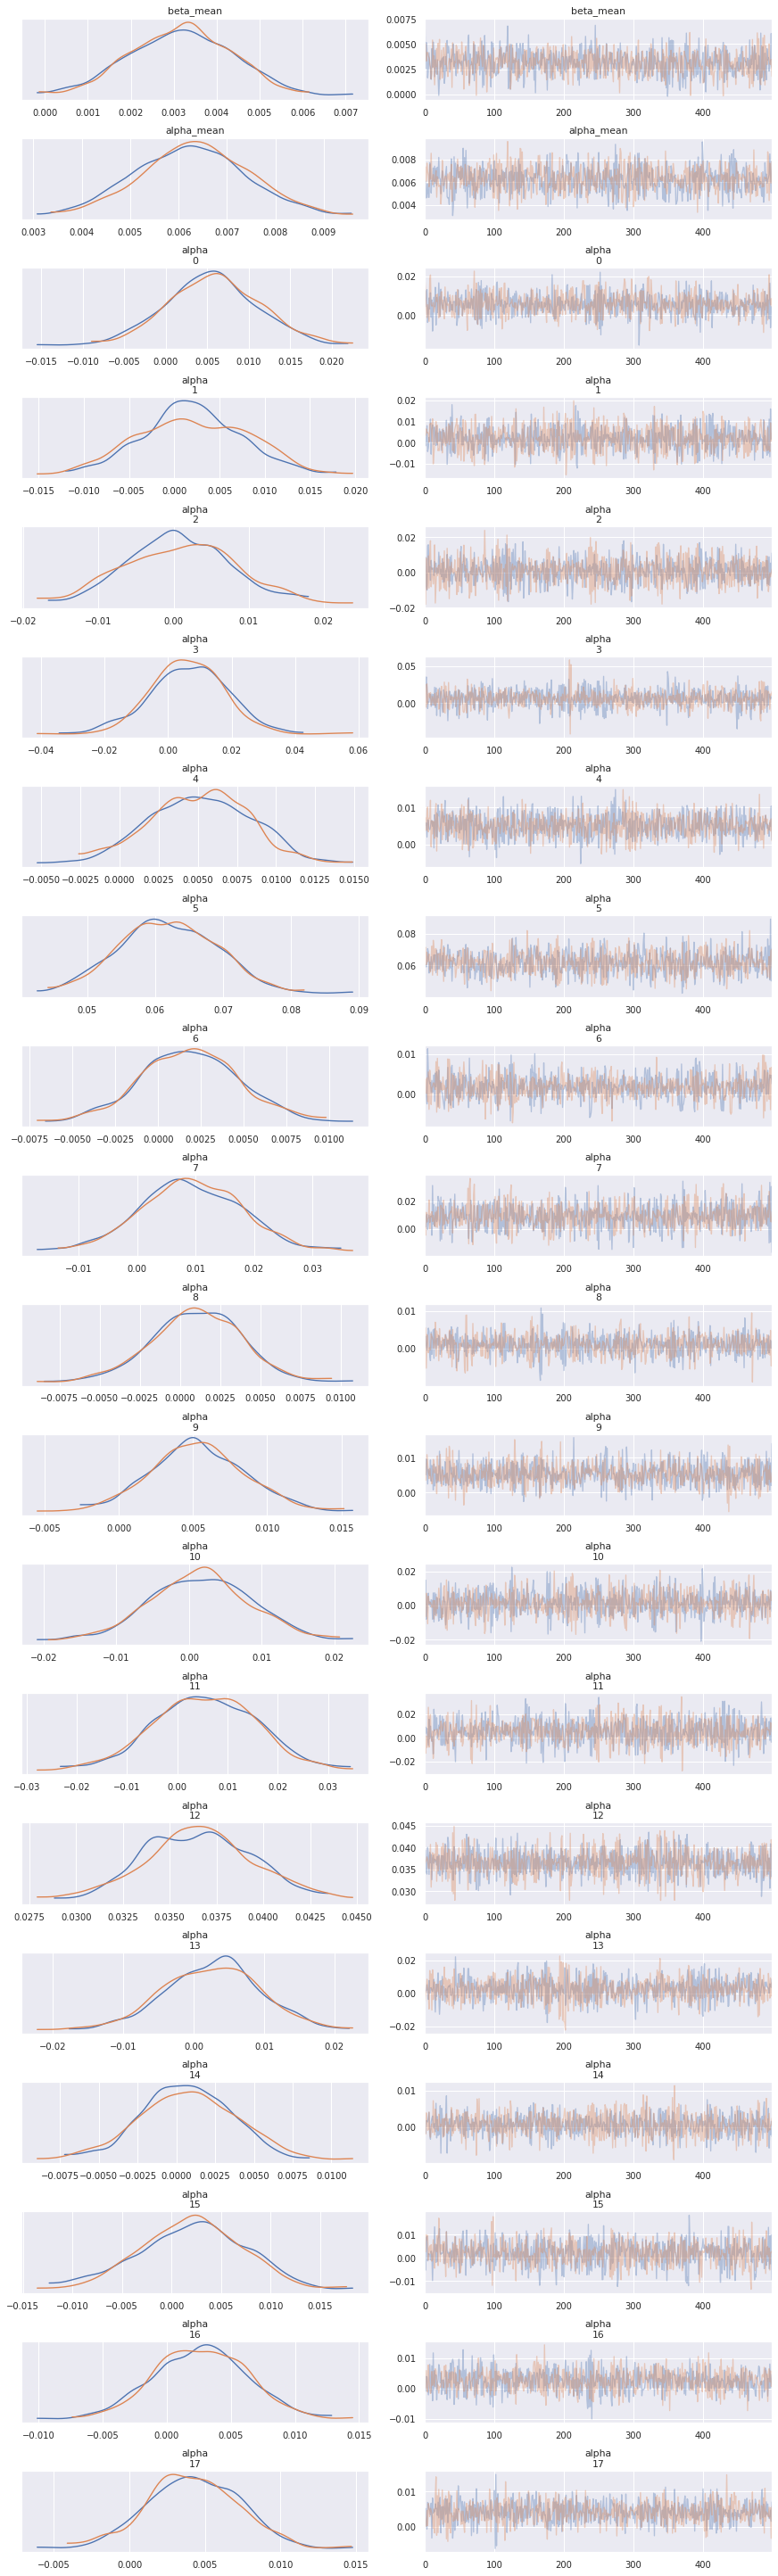

In [704]:
#beta_post = trace['beta'][:]
#alpha_post = trace['alpha'][:]
#obs_sigma_post = trace['obs_sigma'][:]

_= az.plot_trace(trace)
print (az.summary(trace,round_to=2))

#result = pd.DataFrame({'beta_post' : beta_post,
                      #'alpha_post' : alpha_post,
                      #'obs_sigma_post' : obs_sigma_post})

#result.describe()

In [705]:
beta_ci = np.percentile(result['beta_mean'],[5.5,94.5])
alpha_ci = np.percentile(result['alpha_mean'],[5.5,94.5])


In [706]:
result.describe()

beta_mean   alpha_mean     alpha__0     alpha__1     alpha__2  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.003156     0.006283     0.005624     0.001972     0.000748   
std       0.001202     0.001103     0.005459     0.005712     0.007131   
min      -0.000179     0.003080    -0.015501    -0.015165    -0.018183   
25%       0.002321     0.005529     0.002042    -0.001699    -0.004183   
50%       0.003187     0.006287     0.005644     0.001865     0.000610   
75%       0.004026     0.007023     0.009174     0.006066     0.005616   
max       0.007165     0.009596     0.022551     0.019724     0.023883   

          alpha__3     alpha__4     alpha__5     alpha__6     alpha__7  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.006164     0.005088     0.061848     0.001833     0.009245  ...   
std       0.011587     0.003146     0.007029     0.002903     0.008779  ...   
min      -0.041199    -0.005265     0.042626    -0.007071    -0.017064  ...   
25%      -0.001294     0.002875     0.056956    -0.000110     0.003297  ...   
50%       0.005993     0.005202     0.061606     0.001799     0.008969  ...   
75%       0.013903     0.007276     0.066716     0.003770     0.015272  ...   
max       0.058136     0.014896     0.089096     0.011376     0.036861  ...   

         beta__159    beta__160    beta__161    beta__162    beta__163  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.000774     0.010483    -0.000347     0.001404    -0.001016   
std       0.003342     0.004326     0.005254     0.005196     0.006657   
min      -0.008974    -0.004935    -0.017732    -0.015729    -0.028321   
25%      -0.001483     0.007212    -0.003911    -0.002155    -0.005707   
50%       0.000748     0.010580    -0.000362     0.001541    -0.001059   
75%       0.003091     0.013594     0.003079     0.004823     0.003528   
max       0.012272     0.023172     0.016573     0.015653     0.019549   

         beta__164    beta__165  beta_mean_std  alpha_mean_std    obs_sigma  
count  1000.000000  1000.000000    1000.000000     1000.000000  1000.000000  
mean      0.002853     0.000553       0.013396        0.011924     0.036276  
std       0.007017     0.009087       0.001028        0.000901     0.000174  
min      -0.024398    -0.027913       0.010497        0.009325     0.035689  
25%      -0.001608    -0.005790       0.012660        0.011280     0.036162  
50%       0.002890     0.000487       0.013312        0.011891     0.036275  
75%       0.007500     0.006961       0.014028        0.012526     0.036384  
max       0.026861     0.033240       0.017156        0.015359     0.036869  

[8 rows x 337 columns]

In [707]:

X = np.linspace(-3,3,5)
mean_req = np.array([X[i] * result['beta_mean'].mean() + result['alpha_mean'].mean() for i in range(len(X))])

slope,intercept,_,_,_ = sps.linregress(foo['oxford_curr_std'],foo['dead_per_M_std_inc'])

least_squares = np.array([X[i] * slope + intercept for i in range(len(X))])

In [708]:
rows = np.random.choice(result.index,replace=True,size=len(X))
beta_samples = result['beta_mean'][rows]
alpha_samples = result['alpha_mean'][rows]

lines = np.array([X[i] * beta_samples + alpha_samples for i in range(len(X))])


samples = np.array([pm.Normal.dist(X[i] * result.beta_mean[rows] + result.alpha_mean[rows],
                                      result.obs_sigma[rows]).random(size=len(X)) for i in range(len(X))])

high,low = np.percentile(samples,[5.5,94.5],axis=1)


lines

array([[-0.00411912, -0.01055829, -0.0005985 , -0.0045979 , -0.00692128],
       [ 0.0009639 , -0.00224603,  0.00306504,  0.00102005, -0.00090963],
       [ 0.00604691,  0.00606624,  0.00672858,  0.006638  ,  0.00510202],
       [ 0.01112993,  0.0143785 ,  0.01039212,  0.01225595,  0.01111367],
       [ 0.01621294,  0.02269077,  0.01405567,  0.0178739 ,  0.01712532]])

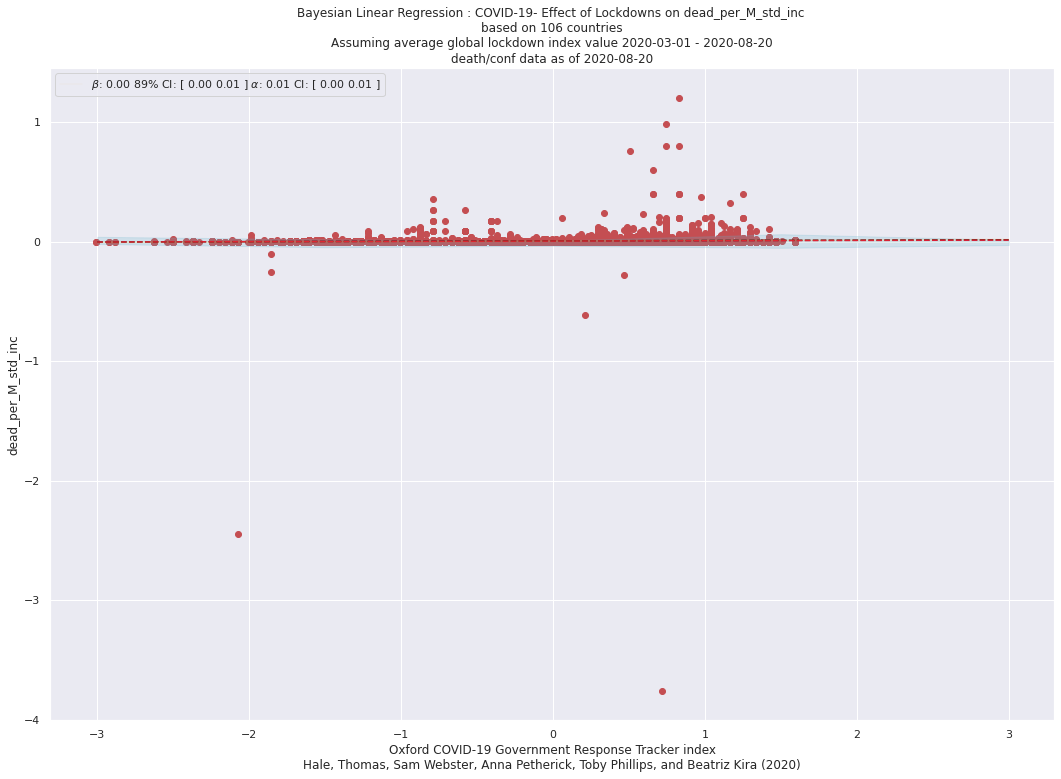

In [709]:
plt.figure(figsize=(18,12))
plt.title('Bayesian Linear Regression : COVID-19'\
          '- Effect of Lockdowns on {} \n'.format(y_param)+\
          'based on {} countries\n'.format(len(last_days))+\
          'Assuming average global lockdown index value {} - {}\n'.format(start_date,end_date)+\
         'death/conf data as of {}'.format(end_date))

plt.scatter(foo['oxford_curr_std'],foo['dead_per_M_std_inc'],color='r')
plt.ylabel(y_param)
plt.xlabel('Oxford COVID-19 Government Response Tracker index\nHale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira (2020)')

plt.plot(X,mean_req,ls='dashed',color='k')
plt.plot(X,least_squares,ls='dashed',color='crimson')

plt.fill_between(X,high,low,color='c',alpha=0.2)

countries_of_interest = ['SWE','GBR','BEL','ESP','ITA','PER','FRA',
                         'USA','DNK','FIN','NOR','BRA','CHL','QAT','BHR',
                        'HNT','GTM','NIC','JPN','ISL','ARG','NLD','DEU','ZAF','HND','IRQ']

#for i,p in enumerate(foo['oxford_curr_std']):
    #if last_days.iloc[i]['abb'] in countries_of_interest:
    #plt.text(foo.iloc[i]['oxford_curr_std'],foo.iloc[i]['dead_per_M_std_inc'],foo.iloc[i]['abb'])

plt.plot(X,lines[0,:],
         color='orange',
         alpha=0.03,
         label=r'$\beta$: {:.2f} 89% CI: [ {:.2f} {:.2f} ] $\alpha$: {:.2f} CI: [ {:.2f} {:.2f} ]'.format(
         result.beta_mean.mean(),beta_ci[0],beta_ci[1],result.alpha_mean.mean(),alpha_ci[0],alpha_ci[1]))

_=plt.plot(X,lines,color='orange',alpha=0.03)

plt.legend(loc='upper left')

plt.savefig('lockdown_index_{}.jpg'.format(y_param),format='jpg',dpi=400)

In [710]:
foo.dropna(inplace=True)

<ipython-input-710-c0916f8ba34f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foo.dropna(inplace=True)


In [711]:
countries = foo.groupby('country')
some_countries = ['Sweden','Belgium','UK','South Africa','Germany','US',
                  'Denmark','Australia','Italy','France','Argentina','Brazil','Chile','Peru']

colors = ['black','grey','lightcoral','mistyrose','tan','gold','crimson','yellow',
         'deepskyblue','royalblue','orangered','lime','aqua','darkmagenta']



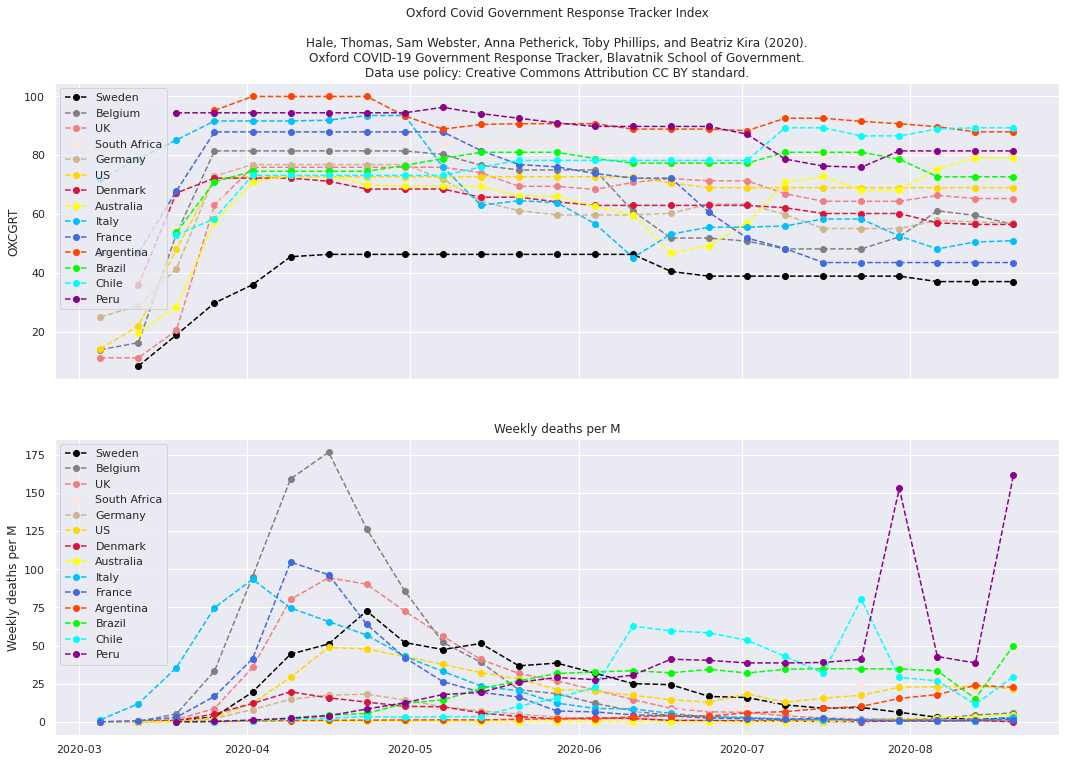

In [712]:
from datetime import datetime

weeklies = dict()

fig,ax = plt.subplots(2,1,sharex=True,figsize=(18,12))


for i,c in enumerate(some_countries):
    country = (countries.get_group(c)).copy()
    country.set_index('date',inplace=True)
    country['dead_inc'] = country['dead'] - country['dead'].shift()
    country['dead_inc_per_M'] = country['dead_inc'] / (country['pop'] / 1e6)
    
    resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
    
    #today = datetime.today().weekday()
    last_data_day = last_data_date.weekday()

    #yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]
    period = resample_period[last_data_day]
    
    weekly = country.resample(period).agg({'dead_inc_per_M' : np.sum, 'dead_per_M' :np.sum,
                                           'oxford_stringency_current' : np.mean})
    
    weeklies[c] = weekly
        
    ax[1].plot(weekly.index,weekly['dead_inc_per_M'],'o--',label=c,color=colors[i])
    ax[0].plot(weekly.index,weekly['oxford_stringency_current'],'o--',label=c,color=colors[i])
 
citation = '\nHale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira (2020).\nOxford COVID-19 Government Response Tracker, Blavatnik School of Government.\nData use policy: Creative Commons Attribution CC BY standard.'
ax[0].legend(loc='upper left')
ax[0].set_title('Oxford Covid Government Response Tracker Index\n' + citation)
ax[0].set_ylabel('OXCGRT')
#ax[0].set_yscale('log')
ax[1].legend(loc='upper left')
ax[1].set_title('Weekly deaths per M')
ax[1].set_ylabel('Weekly deaths per M')
#ax[1].set_yscale('log')
plt.savefig('oxcgrt_country_plot.jpg',format='jpg',dpi=400)

In [713]:

def inference(x,y):
    
    beta_mean = 0
    beta_std = 10
    alpha_low = -500
    alpha_high = 500
    obs_sigma_high = 1000
    
    model = pm.Model()
    
    with model:

        alpha = pm.Uniform('alpha',alpha_low,alpha_high)
        beta = pm.Normal('beta',mu=beta_mean,sd=beta_std)
        obs_sigma = pm.Uniform('obs_sigma',0,obs_sigma_high)

        linreq = alpha + x.values * beta

        obs = pm.Normal('obs',mu = linreq,tau = 1 / obs_sigma ** 2,observed = y)

        trace = pm.sample(1000,tune=1000)   

        beta_post = trace['beta'][:]
        alpha_post = trace['alpha'][:]
        obs_sigma_post = trace['obs_sigma'][:]

        result = pd.DataFrame({'beta_post' : beta_post,
                              'alpha_post' : alpha_post,
                              'obs_sigma_post' : obs_sigma_post})
        _= az.plot_trace(trace)
        print (az.summary(trace,round_to=2))
        
        

        return result


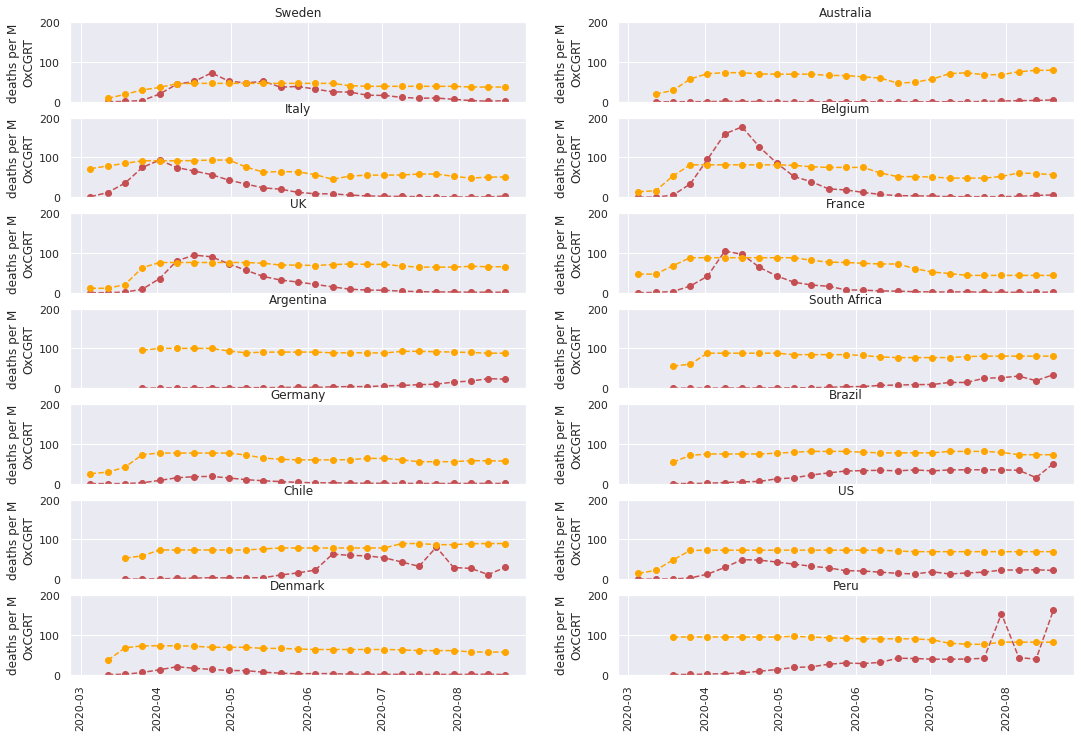

In [714]:
import scipy.stats as sps

weeklies_df = pd.DataFrame()


fig,axes = plt.subplots(7,2,sharex=True,figsize=(18,12))

for i,k in enumerate(weeklies.keys()):
        
    weeklies[k]['country'] = k
        
    weeklies_df = pd.concat([weeklies_df,weeklies[k]])
    
    
    axes[i % 7,i % 2].plot(weeklies[k].index,weeklies[k]['dead_inc_per_M'],'o--',label='weekly deaths per M',
                           color='r')
    axes[i % 7,i % 2].plot(weeklies[k].index,weeklies[k]['oxford_stringency_current'],'o--',label='weekly deaths per M',
                           color='orange')
    axes[i % 7,i % 2].tick_params('x',rotation=90)
    axes[i % 7,i % 2].set_title('{}'.format(k))
    axes[i % 7, i % 2].set_ylabel('deaths per M\nOxCGRT')
    axes[i % 7, i % 2].set_ylim([0,200])
    #axes[i % 7, i % 2].set_yscale('log')
    
plt.savefig('oxcgrt_14.jpg',format='jpg',dpi=400)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        1.55   0.39      0.88       2.14       0.02     0.01    631.25   
alpha     -36.62  15.80    -63.24     -12.85       0.62     0.44    640.48   
obs_sigma  16.59   2.65     12.51      20.41       0.10     0.07    685.03   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       629.80    633.39    627.89    1.0  
alpha      637.17    642.43    665.49    1.0  
obs_sigma  685.03    621.49    353.65    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8914542938456285, but should be close to 0.8. Try to increase the number of tuning steps.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        1.72   0.49      0.96       2.52       0.02     0.01    613.51   
alpha     -71.69  31.34   -124.68     -24.64       1.28     0.94    604.00   
obs_sigma  44.04   7.21     32.69      54.16       0.25     0.17    864.98   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       576.58    619.81    609.69   1.00  
alpha      553.65    608.39    578.48   1.00  
obs_sigma  864.98    782.41    531.69   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        0.73   0.33      0.24       1.26       0.01     0.01    588.38   
alpha     -21.90  21.88    -56.49      11.36       0.91     0.68    581.59   
obs_sigma  29.52   4.68     22.74      36.79       0.19     0.14    588.53   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       549.71    597.74    613.21   1.00  
alpha      514.30    591.11    565.96   1.00  
obs_sigma  588.53    553.63    453.43   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6617777351543175, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        0.01   0.33     -0.55       0.48       0.04     0.03     86.35   
alpha       8.11  26.71    -29.28      53.21       2.79     1.98     91.56   
obs_sigma  12.15   1.97      9.55      15.42       0.17     0.12    128.41   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta        86.35     83.47    519.03   1.04  
alpha       91.56     88.03    502.62   1.04  
obs_sigma  128.41     95.29     56.11   1.03  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8878450462318943, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


            mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        0.30  0.07      0.19       0.41       0.00     0.00    550.20   
alpha     -13.81  4.32    -20.79      -7.36       0.19     0.13    545.27   
obs_sigma   4.58  0.69      3.44       5.52       0.03     0.02    618.21   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       550.20    555.67    761.56   1.01  
alpha      543.22    546.88    688.47   1.01  
obs_sigma  618.21    546.50    335.76   1.00  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        0.51   0.17      0.23       0.75       0.01     0.01    458.53   
alpha     -12.65  11.24    -30.20       4.39       0.52     0.38    467.21   
obs_sigma  12.13   2.05      9.23      15.21       0.09     0.06    563.08   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       440.63    464.66    616.22   1.01  
alpha      435.39    470.78    650.58   1.01  
obs_sigma  563.08    543.47    530.44   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        0.47  0.13      0.27       0.67       0.01     0.00    456.52   
alpha     -25.42  8.41    -38.99     -12.94       0.39     0.28    461.50   
obs_sigma   4.84  0.73      3.76       5.92       0.03     0.02    491.63   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       456.52    463.81    489.01    1.0  
alpha      461.50    467.27    510.32    1.0  
obs_sigma  491.63    420.97    275.97    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


           mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta       0.04  0.02      0.01       0.06       0.00     0.00    626.09   
alpha     -1.73  1.10     -3.51      -0.04       0.05     0.03    601.80   
obs_sigma  1.17  0.18      0.86       1.42       0.01     0.00    876.21   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       617.51    626.31    693.39    1.0  
alpha      590.22    603.07    643.58    1.0  
obs_sigma  864.72    894.51    726.20    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        1.49   0.19      1.18       1.80       0.01     0.01    632.98   
alpha     -77.85  13.32    -99.99     -57.12       0.53     0.38    628.51   
obs_sigma  15.01   2.61     11.34      18.81       0.12     0.08    481.94   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       632.42    632.35    754.88   1.00  
alpha      623.25    629.90    759.39   1.00  
obs_sigma  481.94    442.41    214.76   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        1.09   0.27      0.70       1.54       0.01     0.01    632.09   
alpha     -53.71  18.45    -81.80     -24.67       0.74     0.54    618.07   
obs_sigma  23.48   3.88     17.64      29.45       0.16     0.11    588.76   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       602.74    641.11    798.23   1.01  
alpha      579.73    623.83    707.87   1.01  
obs_sigma  588.76    541.49    401.21   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta       -0.86   0.37     -1.44      -0.29       0.02     0.01    444.74   
alpha      85.72  34.35     30.29     136.79       1.63     1.16    443.91   
obs_sigma   7.19   1.24      5.51       8.96       0.08     0.06    224.05   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       438.02    448.78    502.44   1.00  
alpha      438.17    447.27    496.76   1.00  
obs_sigma  224.05    192.14    119.50   1.02  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        1.28   0.51      0.46       2.08       0.02     0.02    423.27   
alpha     -74.85  38.62   -138.96     -14.29       1.89     1.42    416.85   
obs_sigma  14.23   2.19     10.93      17.45       0.11     0.08    423.20   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       382.58    421.01    390.46   1.00  
alpha      369.16    418.45    364.53   1.00  
obs_sigma  423.20    353.09    108.46   1.02  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        1.33   0.55      0.50       2.21       0.03     0.02    376.51   
alpha     -79.43  42.79   -149.41     -14.24       2.21     1.56    376.16   
obs_sigma  23.45   3.83     17.73      29.59       0.20     0.14    358.09   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       376.51    374.79    582.55   1.00  
alpha      376.16    374.50    552.19   1.00  
obs_sigma  358.09    284.99    119.95   1.02  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


             mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        -3.51   0.91     -5.05      -2.11       0.07     0.05    181.55   
alpha      345.80  81.19    241.07     496.40       6.01     4.25    182.70   
obs_sigma   36.70   6.19     27.71      46.04       0.44     0.31    197.20   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       181.55    192.71    155.08   1.01  
alpha      182.70    192.97    142.07   1.01  
obs_sigma  197.20    203.06    576.62   1.01  


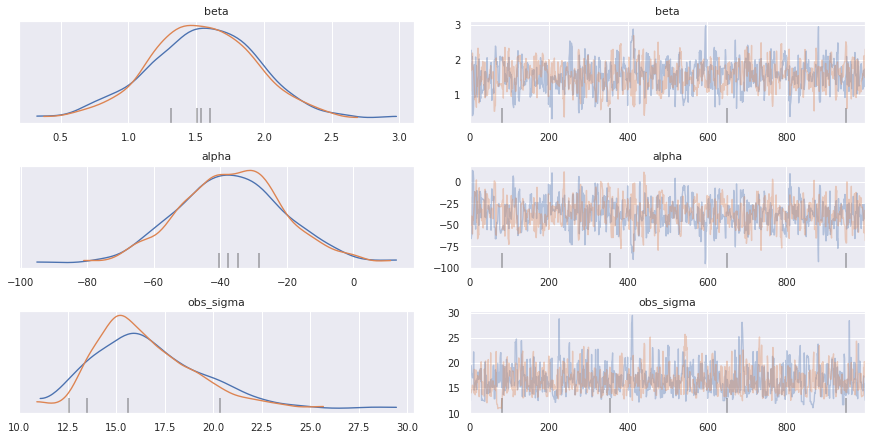

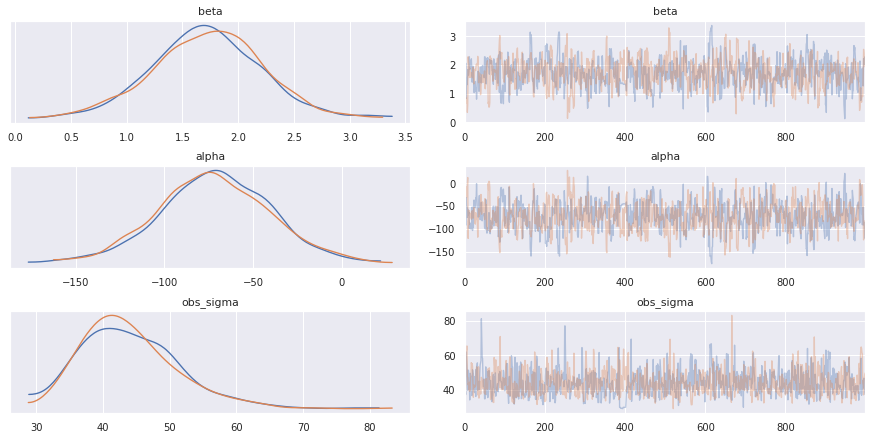

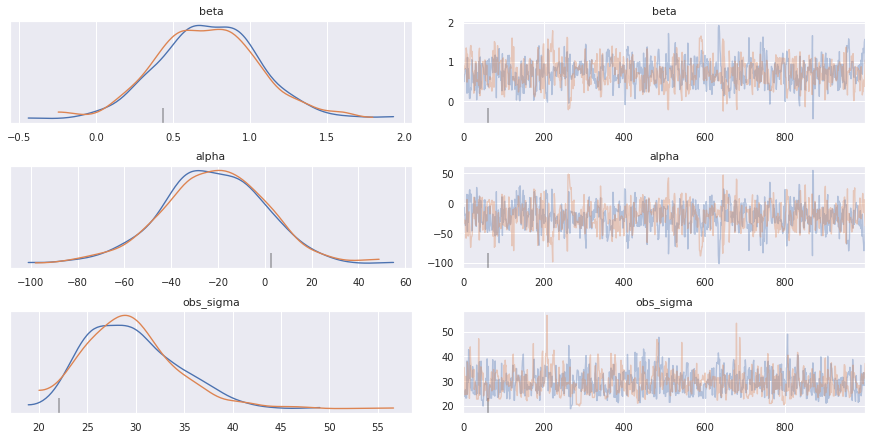

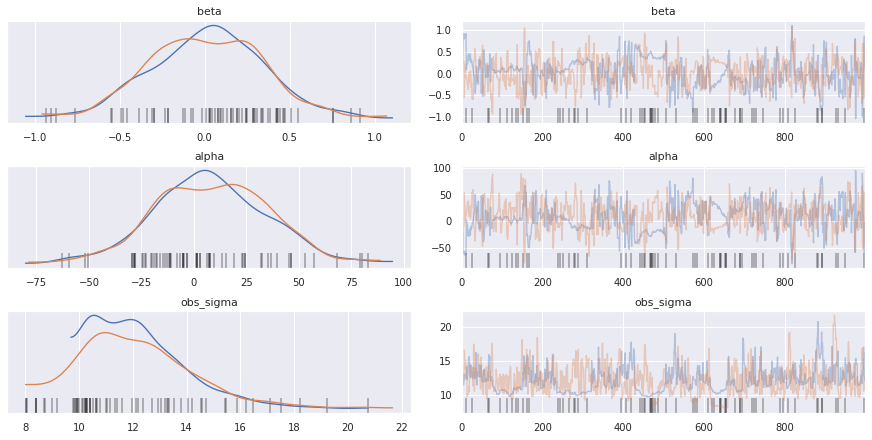

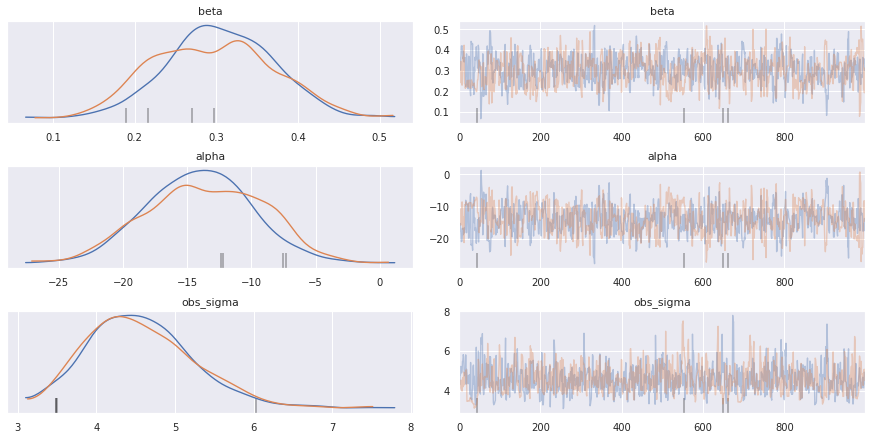

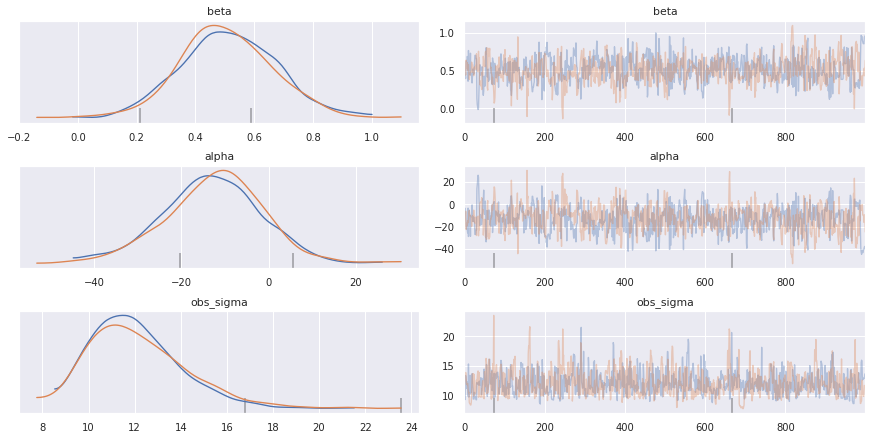

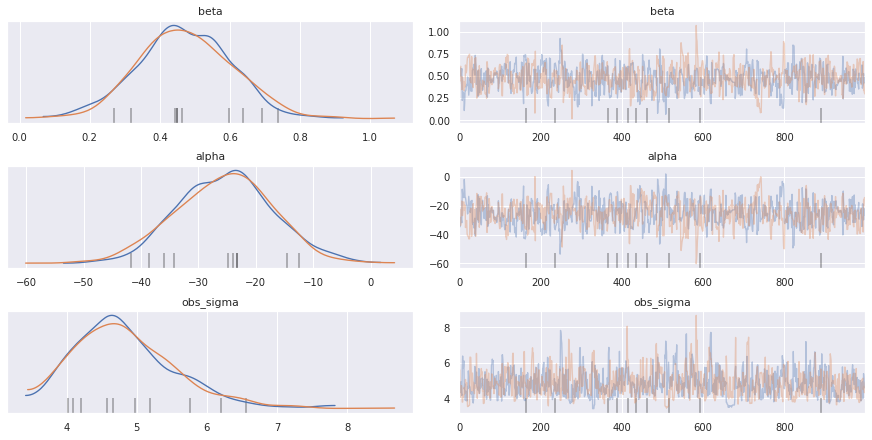

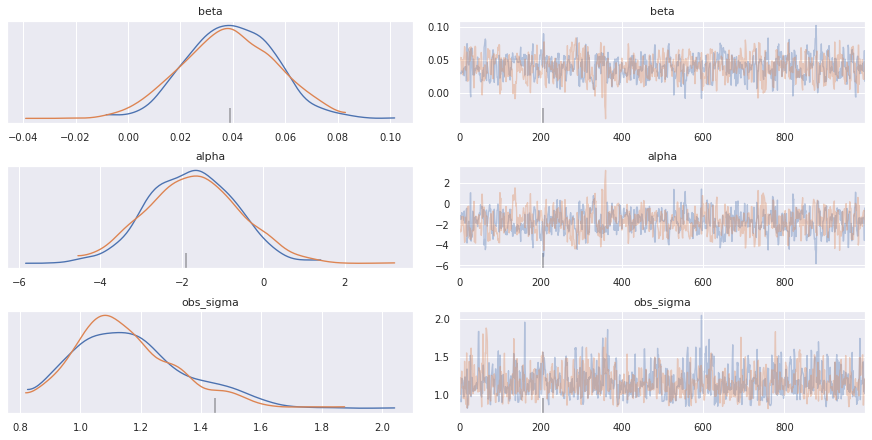

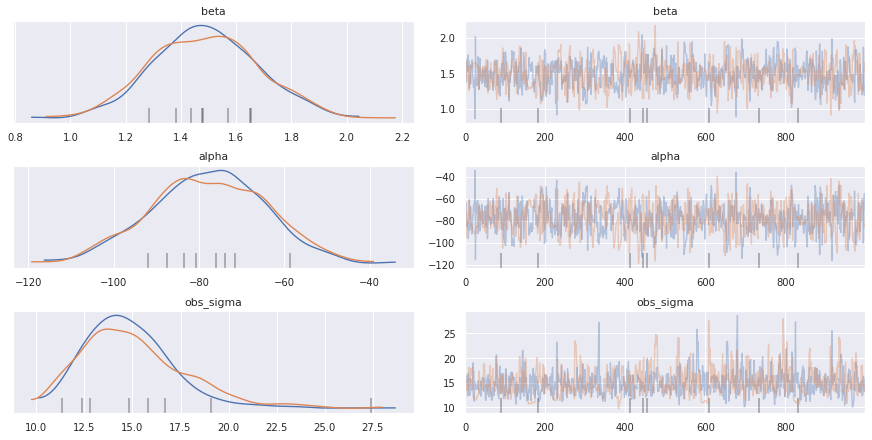

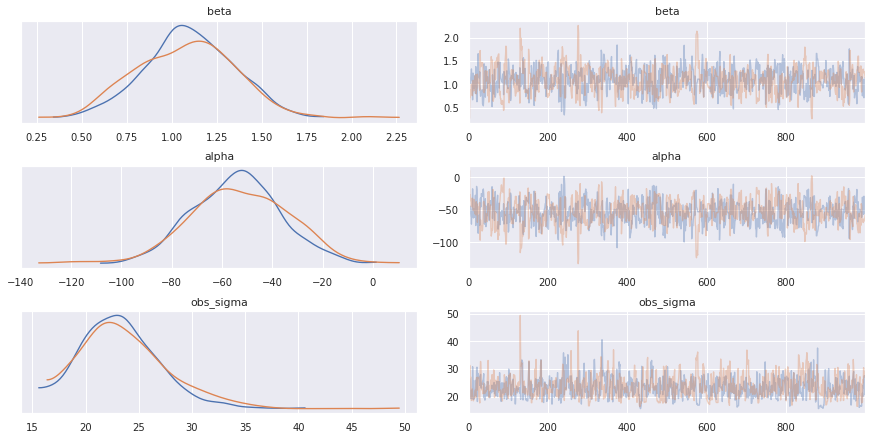

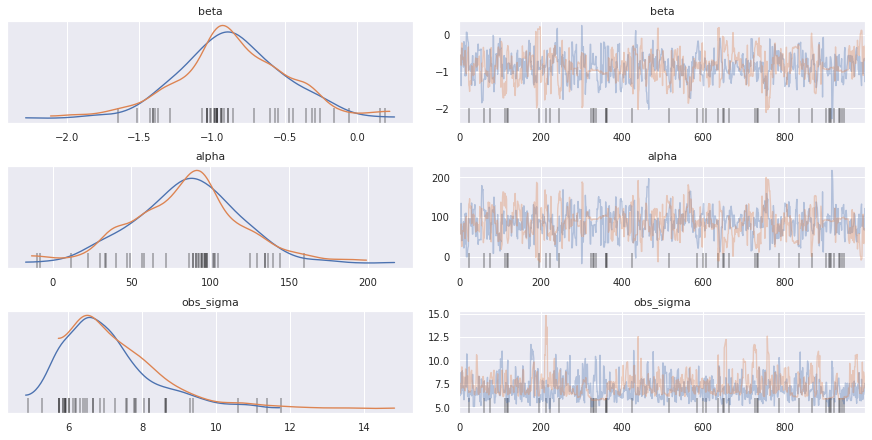

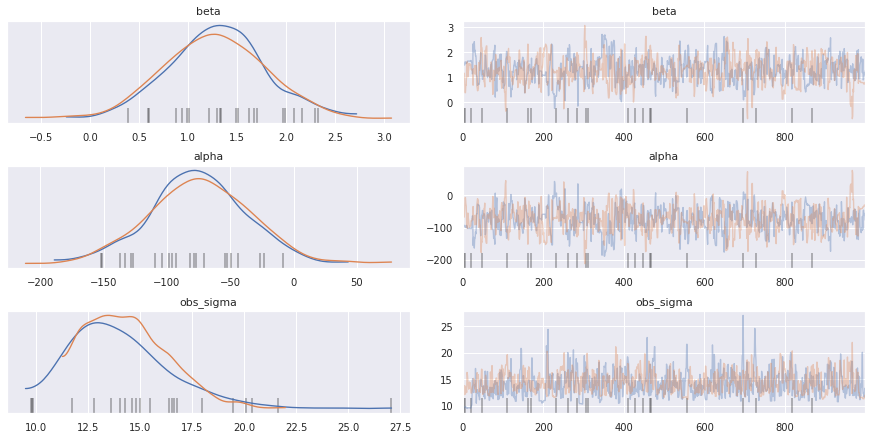

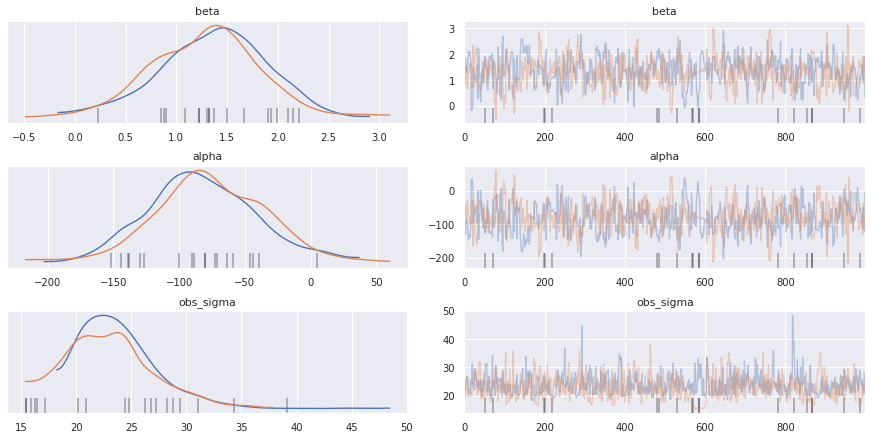

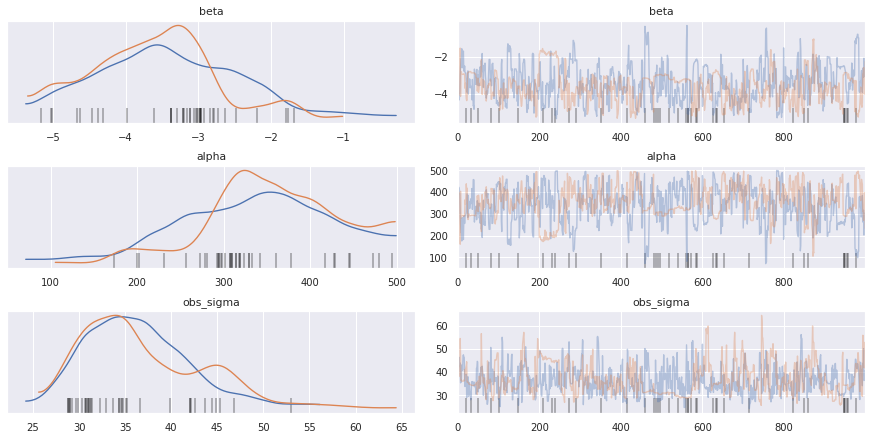

In [715]:
results = dict()

for i,k in enumerate(weeklies.keys()):

    results[k] = inference(weeklies[k]['oxford_stringency_current'],weeklies[k]['dead_inc_per_M'])



In [716]:


print (results['Argentina'].describe())
results['Sweden'].describe()


         beta_post   alpha_post  obs_sigma_post
count  2000.000000  2000.000000     2000.000000
mean     -0.862867    85.720865        7.194625
std       0.372682    34.348507        1.242710
min      -2.283922   -17.063044        4.843178
25%      -1.080333    63.185599        6.352335
50%      -0.878440    87.210021        6.936912
75%      -0.622348   105.649255        7.786113
max       0.256522   216.849877       14.813028


beta_post   alpha_post  obs_sigma_post
count  2000.000000  2000.000000     2000.000000
mean      1.550191   -36.617107       16.590615
std       0.393123    15.801801        2.653750
min       0.323465   -95.181694       10.911558
25%       1.293761   -47.047679       14.730227
50%       1.550113   -36.705920       16.172554
75%       1.815680   -26.382151       18.119428
max       2.977654    12.920667       29.439818

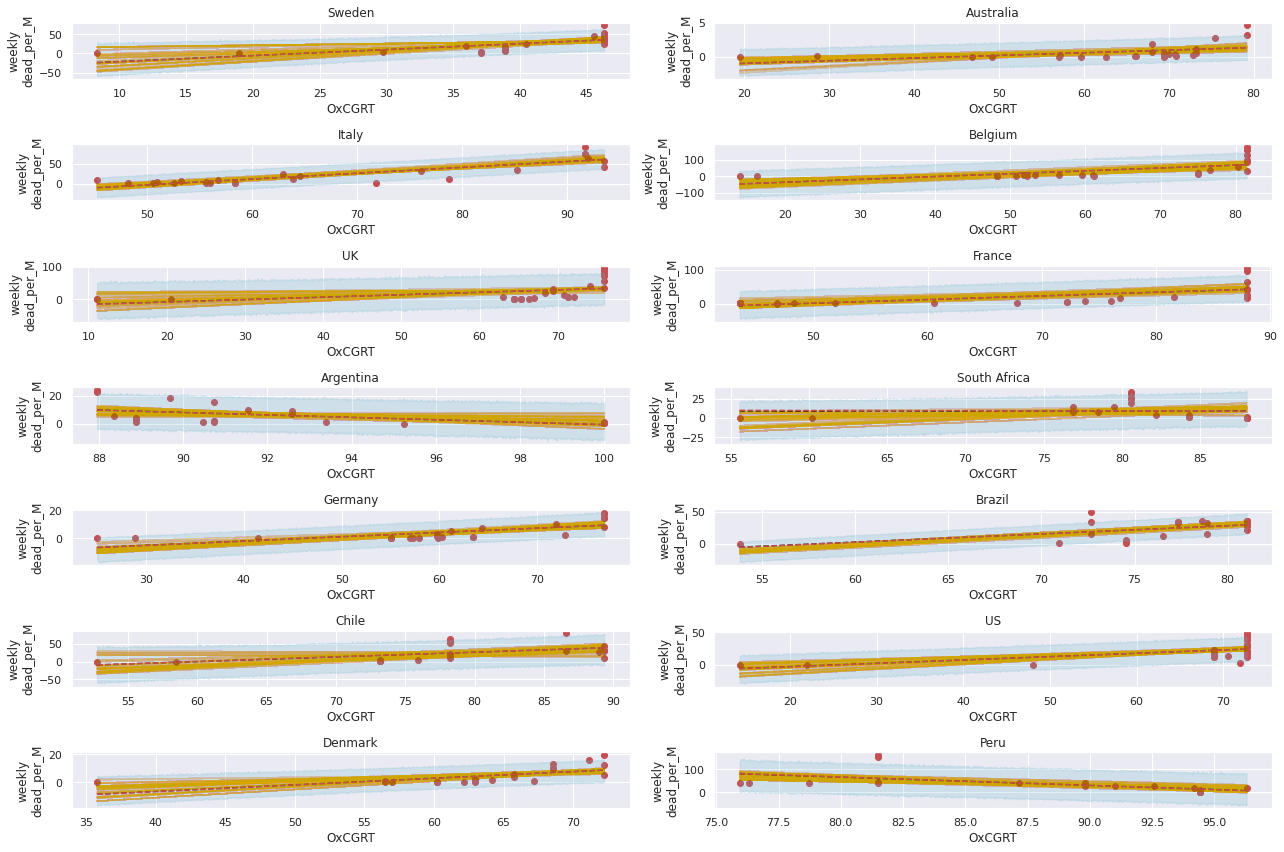

In [717]:
fig,axes = plt.subplots(7,2,figsize=(18,12))

nr_samples = 1000

for i,k in enumerate(weeklies.keys()):

    axes[i % 7,i %2].scatter(weeklies[k]['oxford_stringency_current'],weeklies[k]['dead_inc_per_M'],color='r')

    slope,intercept,_,_,_ = sps.linregress(weeklies[k]['oxford_stringency_current'],
                                           weeklies[k]['dead_inc_per_M'])

    X = np.linspace(weeklies[k]['oxford_stringency_current'].min(),
                    weeklies[k]['oxford_stringency_current'].max(),nr_samples)
        
    #X = np.linspace(0,100,nr_samples) # for computing samples, this must concur with nr of sample rows
    
    alpha_mean = results[k].alpha_post.mean()
    beta_mean = results[k].beta_post.mean()
    
    axes[i % 7, i %2].plot(X,X*beta_mean + alpha_mean,'--',color='k')
    
    rows = np.random.choice(range(len(weeklies[k].index)),replace=True,size=nr_samples)
    
    lines = [X[i] * results[k].iloc[rows].beta_post + results[k].iloc[rows].alpha_post for i in range(len(X))]
    
    samples = np.array([pm.Normal.dist(X[i] * results[k].iloc[rows].beta_post + results[k].iloc[rows].alpha_post,
                                      results[k].iloc[rows].obs_sigma_post).random(size=len(X)) for i in range(len(X))])

    high,low = np.percentile(samples,[5.5,94.5],axis=1)
    
    axes[i % 7, i % 2].plot(X,lines,color='orange',alpha=0.01)
    
    least_squares = X * slope + intercept

    axes[i % 7, i % 2].plot(X,least_squares,'--',color='r')
    
    axes[i % 7, i % 2].fill_between(X,high,low,color='c',alpha=0.2)

    
    axes[i % 7, i % 2].set_title(k)
    axes[i % 7, i % 2].set_ylabel('weekly\ndead_per_M')
    axes[i % 7, i % 2].set_xlabel('OxCGRT')
    #axes[i % 7,i % 2].set_ylim([0,150])
    
plt.tight_layout()
plt.savefig('OxCGRT_regression_14.jpg',format='jpg',dpi=400)

In [718]:
swe_weekly = weeklies_df.loc[weeklies_df['country'] == 'Sweden']
bel_weekly = weeklies_df.loc[weeklies_df['country'] == 'Belgium']
arg_weekly = weeklies_df.loc[weeklies_df['country'] == 'Argentina']

In [719]:
swe_weekly

dead_inc_per_M   dead_per_M  oxford_stringency_current country
date                                                                      
2020-03-12        0.099017     0.099017                   8.333333  Sweden
2020-03-19        0.891154     3.069530                  18.917143  Sweden
2020-03-26        3.168547    16.832908                  29.760000  Sweden
2020-04-02       19.506370    92.580995                  35.981429  Sweden
2020-04-09       44.359664   311.309783                  45.505714  Sweden
2020-04-16       51.092827   653.908973                  46.300000  Sweden
2020-04-23       72.678556  1095.723303                  46.300000  Sweden
2020-04-30       51.983981  1549.617720                  46.300000  Sweden
2020-05-07       47.429194  1896.276610                  46.300000  Sweden
2020-05-14       51.389878  2246.599134                  46.300000  Sweden
2020-05-21       36.735347  2554.641353                  46.300000  Sweden
2020-05-28       38.517655  2788.321724                  46.300000  Sweden
2020-06-04       31.883508  3051.608211                  46.300000  Sweden
2020-06-11       25.051328  3240.037765                  46.300000  Sweden
2020-06-18       24.358208  3394.999537                  40.477143  Sweden
2020-06-25       16.634874  3535.306777                  38.890000  Sweden
2020-07-02       15.941754  3671.851367                  38.890000  Sweden
2020-07-09       11.089916  3765.917619                  38.890000  Sweden
2020-07-16        8.911540  3835.031559                  38.890000  Sweden
2020-07-23        9.406625  3901.472038                  38.890000  Sweden
2020-07-30        6.238078  3950.683540                  38.890000  Sweden
2020-08-06        2.970513  3982.369014                  37.040000  Sweden
2020-08-13        1.386239  3996.528460                  37.040000  Sweden
2020-08-20        2.772479  4010.588889                  37.040000  Sweden

<AxesSubplot:xlabel='date'>

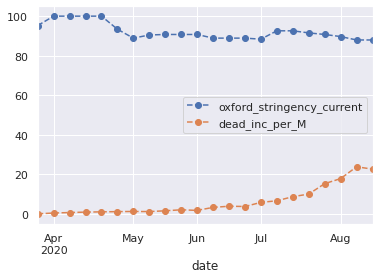

In [720]:

arg_weekly.plot(y=['oxford_stringency_current','dead_inc_per_M'],style='o--')

In [721]:
all_countries = pd.DataFrame()

for c in countries.groups:
    country = countries.get_group(c)
    inc = country['dead'] - country['dead'].shift()
    inc.name='inc'
    country = pd.concat([country,inc],axis=1)
    
    country = country.replace(np.inf,np.nan)
    country = country.dropna()
    all_countries = pd.concat([all_countries,country],axis=0)
    


In [722]:
all_countries.head(50)


date  confirmed   dead  oxford_stringency_current      country  \
198 2020-03-30      114.0    4.0                      67.59  Afghanistan   
199 2020-03-31      141.0    4.0                      67.59  Afghanistan   
200 2020-04-01      166.0    4.0                      67.59  Afghanistan   
201 2020-04-02      192.0    4.0                      67.59  Afghanistan   
202 2020-04-03      235.0    4.0                      67.59  Afghanistan   
203 2020-04-04      235.0    4.0                      67.59  Afghanistan   
204 2020-04-05      270.0    5.0                      78.70  Afghanistan   
205 2020-04-06      299.0    7.0                      78.70  Afghanistan   
206 2020-04-07      337.0    7.0                      78.70  Afghanistan   
207 2020-04-08      367.0   11.0                      78.70  Afghanistan   
208 2020-04-09      423.0   14.0                      78.70  Afghanistan   
209 2020-04-10      484.0   15.0                      78.70  Afghanistan   
210 2020-04-11      521.0   15.0                      78.70  Afghanistan   
211 2020-04-12      555.0   18.0                      84.26  Afghanistan   
212 2020-04-13      607.0   18.0                      84.26  Afghanistan   
213 2020-04-14      665.0   21.0                      84.26  Afghanistan   
214 2020-04-15      714.0   23.0                      84.26  Afghanistan   
215 2020-04-16      784.0   25.0                      84.26  Afghanistan   
216 2020-04-17      794.0   29.0                      84.26  Afghanistan   
217 2020-04-18      845.0   30.0                      84.26  Afghanistan   
218 2020-04-19      908.0   30.0                      84.26  Afghanistan   
219 2020-04-20      996.0   33.0                      84.26  Afghanistan   
220 2020-04-21     1031.0   35.0                      84.26  Afghanistan   
221 2020-04-22     1092.0   36.0                      84.26  Afghanistan   
222 2020-04-23     1176.0   40.0                      84.26  Afghanistan   
223 2020-04-24     1281.0   42.0                      84.26  Afghanistan   
224 2020-04-25     1351.0   43.0                      84.26  Afghanistan   
225 2020-04-26     1463.0   47.0                      84.26  Afghanistan   
226 2020-04-27     1531.0   57.0                      84.26  Afghanistan   
227 2020-04-28     1703.0   57.0                      84.26  Afghanistan   
228 2020-04-29     1827.0   60.0                      84.26  Afghanistan   
229 2020-04-30     1949.0   60.0                      84.26  Afghanistan   
230 2020-05-01     2171.0   64.0                      84.26  Afghanistan   
231 2020-05-02     2335.0   68.0                      84.26  Afghanistan   
232 2020-05-03     2469.0   72.0                      84.26  Afghanistan   
233 2020-05-04     2704.0   85.0                      84.26  Afghanistan   
234 2020-05-05     2894.0   90.0                      84.26  Afghanistan   
235 2020-05-06     3224.0   95.0                      84.26  Afghanistan   
236 2020-05-07     3392.0  104.0                      84.26  Afghanistan   
237 2020-05-08     3563.0  106.0                      84.26  Afghanistan   
238 2020-05-09     3778.0  109.0                      84.26  Afghanistan   
239 2020-05-10     4033.0  115.0                      84.26  Afghanistan   
240 2020-05-11     4402.0  120.0                      84.26  Afghanistan   
241 2020-05-12     4687.0  122.0                      84.26  Afghanistan   
242 2020-05-13     4967.0  127.0                      84.26  Afghanistan   
243 2020-05-14     5226.0  130.0                      84.26  Afghanistan   
244 2020-05-15     5339.0  136.0                      84.26  Afghanistan   
245 2020-05-16     6402.0  168.0                      84.26  Afghanistan   
246 2020-05-17     6402.0  168.0                      84.26  Afghanistan   
247 2020-05-18     6664.0  169.0                      84.26  Afghanistan   

     oxford_stringency_mean       pop  dead_per_M  abb  country_idx  \
198               72.494624  38928346    0.102753  AFG        

In [723]:
select_countries = ['Sweden','UK','Spain','Italy','UK','Belgium','France','US','Germany']
select_countries = ['Sweden','UK','Belgium']

### only one country for plotting below

select_countries = ['Australia']

mask = all_countries['country'].isin(select_countries)

selected_countries = (all_countries[mask]).copy()
selected_countries

date  confirmed   dead  oxford_stringency_current    country  \
1344 2020-03-12      126.0    3.0                      19.44  Australia   
1345 2020-03-13      156.0    3.0                      19.44  Australia   
1346 2020-03-14      197.0    3.0                      19.44  Australia   
1347 2020-03-15      249.0    3.0                      19.44  Australia   
1348 2020-03-16      298.0    5.0                      30.56  Australia   
...         ...        ...    ...                        ...        ...   
1497 2020-08-12    21713.0  331.0                      79.17  Australia   
1498 2020-08-17    23288.0  396.0                      79.17  Australia   
1499 2020-08-18    23599.0  421.0                      79.17  Australia   
1500 2020-08-19    23773.0  438.0                      79.17  Australia   
1501 2020-08-20    23993.0  450.0                      79.17  Australia   

      oxford_stringency_mean       pop  dead_per_M  abb  country_idx  \
1344               61.724556  25499884    0.117648  AUS            8   
1345               61.724556  25499884    0.117648  AUS            8   
1346               61.724556  25499884    0.117648  AUS            8   
1347               61.724556  25499884    0.117648  AUS            8   
1348               61.724556  25499884    0.196079  AUS            8   
...                      ...       ...         ...  ...          ...   
1497               61.724556  25499884   12.980451  AUS            8   
1498               61.724556  25499884   15.529482  AUS            8   
1499               61.724556  25499884   16.509879  AUS            8   
1500               61.724556  25499884   17.176549  AUS            8   
1501               61.724556  25499884   17.647139  AUS            8   

      dead_per_M_std  oxford_curr_std  dead_per_M_std_inc   inc  
1344       -0.372154        -2.115583            0.000000   0.0  
1345       -0.372154        -2.115583            0.000000   0.0  
1346       -0.372154        -2.115583            0.000000   0.0  
1347       -0.372154        -2.115583            0.000000   0.0  
1348       -0.371619        -1.603385            0.000535   2.0  
...              ...              ...                 ...   ...  
1497       -0.284493         0.635638            0.004811  18.0  
1498       -0.267121         0.635638            0.017372  65.0  
1499       -0.260439         0.635638            0.006681  25.0  
1500       -0.255896         0.635638            0.004543  17.0  
1501       -0.252689         0.635638            0.003207  12.0  

[158 rows x 14 columns]

In [724]:
unique_country_abbs = selected_countries['abb'].unique()
print (unique_country_abbs)
country_idx = dict(zip(unique_country_abbs,range(1,len(unique_country_abbs) + 1)))
country_idx    

['AUS']


{'AUS': 1}

In [725]:
unique_days = selected_countries['date'].unique()
day_idx = dict(zip(pd.to_datetime(unique_days),range(1,len(unique_days) + 1)))


In [726]:
def create_country_index(abb):
    return country_idx[abb]

def create_day_index(day):
    return day_idx[day]

selected_countries['country_idx'] = selected_countries['abb'].apply(create_country_index)
selected_countries['day_idx'] = selected_countries['date'].apply(create_day_index)
selected_countries['ox_idx'] = selected_countries['oxford_stringency_current'].astype(int)
selected_countries['inc_per_M'] = selected_countries['inc'] / (selected_countries['pop'] / 1e6)
selected_countries

date  confirmed   dead  oxford_stringency_current    country  \
1344 2020-03-12      126.0    3.0                      19.44  Australia   
1345 2020-03-13      156.0    3.0                      19.44  Australia   
1346 2020-03-14      197.0    3.0                      19.44  Australia   
1347 2020-03-15      249.0    3.0                      19.44  Australia   
1348 2020-03-16      298.0    5.0                      30.56  Australia   
...         ...        ...    ...                        ...        ...   
1497 2020-08-12    21713.0  331.0                      79.17  Australia   
1498 2020-08-17    23288.0  396.0                      79.17  Australia   
1499 2020-08-18    23599.0  421.0                      79.17  Australia   
1500 2020-08-19    23773.0  438.0                      79.17  Australia   
1501 2020-08-20    23993.0  450.0                      79.17  Australia   

      oxford_stringency_mean       pop  dead_per_M  abb  country_idx  \
1344               61.724556  25499884    0.117648  AUS            1   
1345               61.724556  25499884    0.117648  AUS            1   
1346               61.724556  25499884    0.117648  AUS            1   
1347               61.724556  25499884    0.117648  AUS            1   
1348               61.724556  25499884    0.196079  AUS            1   
...                      ...       ...         ...  ...          ...   
1497               61.724556  25499884   12.980451  AUS            1   
1498               61.724556  25499884   15.529482  AUS            1   
1499               61.724556  25499884   16.509879  AUS            1   
1500               61.724556  25499884   17.176549  AUS            1   
1501               61.724556  25499884   17.647139  AUS            1   

      dead_per_M_std  oxford_curr_std  dead_per_M_std_inc   inc  day_idx  \
1344       -0.372154        -2.115583            0.000000   0.0        1   
1345       -0.372154        -2.115583            0.000000   0.0        2   
1346       -0.372154        -2.115583            0.000000   0.0        3   
1347       -0.372154        -2.115583            0.000000   0.0        4   
1348       -0.371619        -1.603385            0.000535   2.0        5   
...              ...              ...                 ...   ...      ...   
1497       -0.284493         0.635638            0.004811  18.0      154   
1498       -0.267121         0.635638            0.017372  65.0      155   
1499       -0.260439         0.635638            0.006681  25.0      156   
1500       -0.255896         0.635638            0.004543  17.0      157   
1501       -0.252689         0.635638            0.003207  12.0      158   

      ox_idx  inc_per_M  
1344      19   0.000000  
1345      19   0.000000  
1346      19   0.000000  
1347      19   0.000000  
1348      30   0.078432  
...      ...        ...  
1497      79   0.705886  
1498      79   2.549031  
1499      79   0.980397  
1500      79   0.666670  
1501      79   0.470590  

[158 rows x 17 columns]

In [727]:
selected_period = selected_countries.set_index('date').resample('d').agg({'oxford_stringency_current' : np.mean,
                                                        'inc':np.sum})

selected_period = selected_period[:-1]

In [728]:
def standardize(S):
    return (S - S.mean()) / S.std()

selected_period['date_idx'] = range(1,len(selected_period) + 1)

selected_period['ox_std'] = standardize(selected_period['oxford_stringency_current'])
selected_period['inc_std'] = standardize(selected_period['inc'])
selected_period



oxford_stringency_current   inc  date_idx    ox_std   inc_std
date                                                                     
2020-03-12                      19.44   0.0         1 -3.656684 -0.415496
2020-03-13                      19.44   0.0         2 -3.656684 -0.415496
2020-03-14                      19.44   0.0         3 -3.656684 -0.415496
2020-03-15                      19.44   0.0         4 -3.656684 -0.415496
2020-03-16                      30.56   2.0         5 -2.755800 -0.107934
...                               ...   ...       ...       ...       ...
2020-08-15                        NaN   0.0       157       NaN -0.415496
2020-08-16                        NaN   0.0       158       NaN -0.415496
2020-08-17                      79.17  65.0       159  1.182325  9.580298
2020-08-18                      79.17  25.0       160  1.182325  3.429040
2020-08-19                      79.17  17.0       161  1.182325  2.198788

[161 rows x 5 columns]

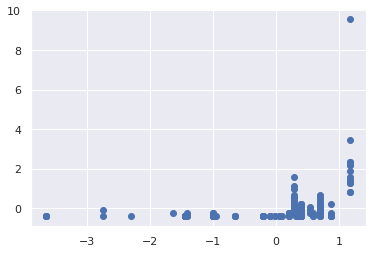

In [729]:
plt.scatter(selected_period['ox_std'],selected_period['inc_std'])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


       mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
alpha   0.0  0.10     -0.15       0.17        0.0      0.0   1803.38  1584.31   
beta   -0.0  0.10     -0.17       0.15        0.0      0.0   1784.11  1466.45   
sigma   1.0  0.06      0.92       1.10        0.0      0.0   2128.36  2124.30   

       ess_bulk  ess_tail  r_hat  
alpha   1800.61   1692.65    1.0  
beta    1784.78   1639.48    1.0  
sigma   2135.74   1906.54    1.0  


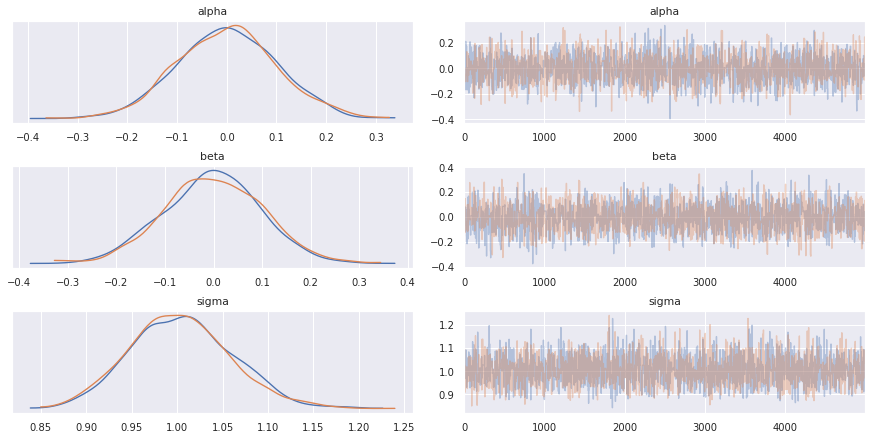

In [730]:
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

model = pm.Model()
with model:
    alpha = pm.Normal('alpha',mu=0,sd=0.1)
    beta = pm.Normal('beta',mu=0,sd=0.1)
    
    sigma = pm.Uniform('sigma',0,10)
    
    reg = alpha + selected_period['ox_std'].values * beta
    
    lkh = pm.Normal('lkh',mu=0,sd=sigma,observed=selected_period['inc_std'])
    
    step1 = pm.Metropolis()
    
    trace = pm.sample(5000,step=step1,tune=5000)
    
    _= az.plot_trace(trace)
    print (az.summary(trace,round_to=2))
    

In [731]:
result = pm.trace_to_dataframe(trace)
result.describe()

alpha          beta         sigma
count  10000.000000  10000.000000  10000.000000
mean       0.000531     -0.001610      1.004596
std        0.099560      0.099950      0.055094
min       -0.395515     -0.377186      0.838673
25%       -0.066180     -0.067605      0.967020
50%        0.002030     -0.000522      1.003265
75%        0.067833      0.067211      1.039564
max        0.338462      0.373533      1.239518

In [732]:
nr_rows = 1000

X = np.linspace(selected_period['ox_std'].min(),selected_period['ox_std'].max(),nr_rows)

rows = np.random.choice(result.index,replace=True,size=nr_rows)

lines = np.array([ result.iloc[i]['alpha'] + X * result.iloc[i]['beta'] for i in range(nr_rows)])

lines

array([[-0.27276954, -0.27212179, -0.27147404, ...,  0.37303483,
         0.37368258,  0.37433033],
       [-0.27276954, -0.27212179, -0.27147404, ...,  0.37303483,
         0.37368258,  0.37433033],
       [-0.27276954, -0.27212179, -0.27147404, ...,  0.37303483,
         0.37368258,  0.37433033],
       ...,
       [-0.34128404, -0.34081486, -0.34034567, ...,  0.12649487,
         0.12696406,  0.12743325],
       [-0.15596387, -0.15574017, -0.15551647, ...,  0.06706582,
         0.06728952,  0.06751323],
       [-0.15596387, -0.15574017, -0.15551647, ...,  0.06706582,
         0.06728952,  0.06751323]])

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0.5, 0, 'Mean Oxford index for period [standardized]')

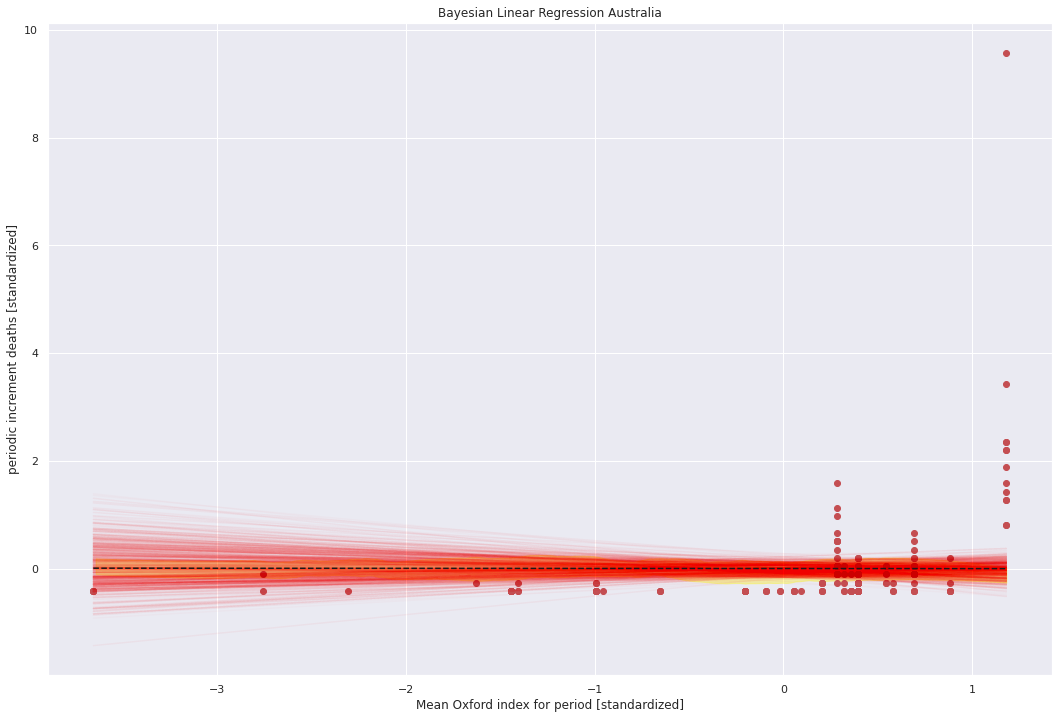

In [733]:
plt.figure(figsize=(18,12))

ax = plt.gca()

plt.title('Bayesian Linear Regression {}'.format(select_countries[0]))

_= [plt.plot(X,lines[i],color='red',alpha=0.02) for i in range(nr_rows)]

plt.plot(X,result.describe().loc['mean','alpha'] + result.describe().loc['mean','beta'] * X,
         '--',color='k')

fill_kwargs = {'alpha': 0.3}
az.plot_hpd(X, lines.T,ax=ax,color='yellow',fill_kwargs=fill_kwargs)


plt.scatter(selected_period['ox_std'],selected_period['inc_std'],color='r')
plt.ylabel('periodic increment deaths [standardized]')
plt.xlabel('Mean Oxford index for period [standardized]')



In [734]:
selected_period

oxford_stringency_current   inc  date_idx    ox_std   inc_std
date                                                                     
2020-03-12                      19.44   0.0         1 -3.656684 -0.415496
2020-03-13                      19.44   0.0         2 -3.656684 -0.415496
2020-03-14                      19.44   0.0         3 -3.656684 -0.415496
2020-03-15                      19.44   0.0         4 -3.656684 -0.415496
2020-03-16                      30.56   2.0         5 -2.755800 -0.107934
...                               ...   ...       ...       ...       ...
2020-08-15                        NaN   0.0       157       NaN -0.415496
2020-08-16                        NaN   0.0       158       NaN -0.415496
2020-08-17                      79.17  65.0       159  1.182325  9.580298
2020-08-18                      79.17  25.0       160  1.182325  3.429040
2020-08-19                      79.17  17.0       161  1.182325  2.198788

[161 rows x 5 columns]

In [735]:
selected_countries

date  confirmed   dead  oxford_stringency_current    country  \
1344 2020-03-12      126.0    3.0                      19.44  Australia   
1345 2020-03-13      156.0    3.0                      19.44  Australia   
1346 2020-03-14      197.0    3.0                      19.44  Australia   
1347 2020-03-15      249.0    3.0                      19.44  Australia   
1348 2020-03-16      298.0    5.0                      30.56  Australia   
...         ...        ...    ...                        ...        ...   
1497 2020-08-12    21713.0  331.0                      79.17  Australia   
1498 2020-08-17    23288.0  396.0                      79.17  Australia   
1499 2020-08-18    23599.0  421.0                      79.17  Australia   
1500 2020-08-19    23773.0  438.0                      79.17  Australia   
1501 2020-08-20    23993.0  450.0                      79.17  Australia   

      oxford_stringency_mean       pop  dead_per_M  abb  country_idx  \
1344               61.724556  25499884    0.117648  AUS            1   
1345               61.724556  25499884    0.117648  AUS            1   
1346               61.724556  25499884    0.117648  AUS            1   
1347               61.724556  25499884    0.117648  AUS            1   
1348               61.724556  25499884    0.196079  AUS            1   
...                      ...       ...         ...  ...          ...   
1497               61.724556  25499884   12.980451  AUS            1   
1498               61.724556  25499884   15.529482  AUS            1   
1499               61.724556  25499884   16.509879  AUS            1   
1500               61.724556  25499884   17.176549  AUS            1   
1501               61.724556  25499884   17.647139  AUS            1   

      dead_per_M_std  oxford_curr_std  dead_per_M_std_inc   inc  day_idx  \
1344       -0.372154        -2.115583            0.000000   0.0        1   
1345       -0.372154        -2.115583            0.000000   0.0        2   
1346       -0.372154        -2.115583            0.000000   0.0        3   
1347       -0.372154        -2.115583            0.000000   0.0        4   
1348       -0.371619        -1.603385            0.000535   2.0        5   
...              ...              ...                 ...   ...      ...   
1497       -0.284493         0.635638            0.004811  18.0      154   
1498       -0.267121         0.635638            0.017372  65.0      155   
1499       -0.260439         0.635638            0.006681  25.0      156   
1500       -0.255896         0.635638            0.004543  17.0      157   
1501       -0.252689         0.635638            0.003207  12.0      158   

      ox_idx  inc_per_M  
1344      19   0.000000  
1345      19   0.000000  
1346      19   0.000000  
1347      19   0.000000  
1348      30   0.078432  
...      ...        ...  
1497      79   0.705886  
1498      79   2.549031  
1499      79   0.980397  
1500      79   0.666670  
1501      79   0.470590  

[158 rows x 17 columns]